In [39]:
import warnings
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from ml_pipeline.data_preparation import DataPreprocessor
from ml_pipeline.model_training import ModelTraining
from config import Config
import joblib
from utils.query_execution import load_create_data
from collections import defaultdict
from wrappers import (
    filter_data_wrapper,
    drop_wrapper,
    convert_dates_wrapper,
    categorical_encoding_wrapper,
    normalization_wrapper,
    pivot_wrapper
)

periodos_estadios = Config.combinacoes_3
# n_variaveis = [5,6,7,8,9,10,11,12]

warnings.filterwarnings("ignore", category=RuntimeWarning)
# query_name = '23_05_2024'
# data = load_create_data(query_name)
data = pd.read_csv('data/csv/23_05_2024.csv')
# data = data_sector


#metricas para cada periodo e cada modelo
metrics = defaultdict(lambda: defaultdict(dict))
for periodos in periodos_estadios:
#use config.columns to filter the data
    data = data[Config.columns]
    data_filtered = data[data['estadio'].isin(periodos)]

    data_prep = DataPreprocessor(data_filtered)

    train_set, validation_set = data_prep.SplitData()

    if not Config.pivot_switch:
        Config.categorical_data.append('estadio')

    hot_encoder, label_encoder = None, None 
    preprocessing_pipeline = Pipeline(steps=[
        ('filter_produtividade', FunctionTransformer(filter_data_wrapper,           kw_args={'data_prep': data_prep})),
        ('dropper',              FunctionTransformer(drop_wrapper,                  kw_args={'columns': Config.columns_to_drop, 'target': Config.target, 'data_prep': data_prep})),
        ('convert_dates',        FunctionTransformer(convert_dates_wrapper,         kw_args={'dates': Config.date_columns, 'data_prep': data_prep})),
        ('pivot',                FunctionTransformer(pivot_wrapper,                 kw_args={'pivot_columns': Config.pivot_columns, 'pivot_switch': Config.pivot_switch, 'data_prep': data_prep})),
        ('normalization',        FunctionTransformer(normalization_wrapper,         kw_args={'scaler': Config.scaler,'target_column': Config.target, 'data_prep': data_prep})),
        ('categorical_encoding', FunctionTransformer(categorical_encoding_wrapper,  kw_args={'target': Config.target, 'categorical_columns': Config.categorical_data, 'data_prep': data_prep })),
    ], verbose=False)

    print("Preprocessing data...")
    X_processed = preprocessing_pipeline.fit_transform(train_set)
    X, y, _, _ = X_processed[0], X_processed[1], X_processed[2], X_processed[3]

    X_valid_processed = preprocessing_pipeline.transform(validation_set)
    X_valid, y_valid, _, _ = X_valid_processed[0], X_valid_processed[1], X_valid_processed[2], X_valid_processed[3]
    for model in Config.models:
        print(f"Training model {model} features and {periodos} periods")
        mTraining = ModelTraining(model, Config.scaler)
        X_train, X_test, y_train, y_test = mTraining.split_data(X, y)

        opt, model123, rmse, r2, mae = mTraining.train_models(X_train, X_test, y_train, y_test, X_valid, y_valid, n_features_select=None, R_Feature_Selection=False)
        metrics[model][str(periodos)] = {'rmse': rmse, 'r2': r2, 'mae': mae}
        
        save_path = f'saves/{model}/{str(periodos)}]'
        if not os.path.exists(save_path):
            os.makedirs(f'saves/{model}/{str(periodos)}]')
        joblib.dump(mTraining.model, f'{save_path}/model.pkl')
            
metrics_df = pd.DataFrame([{**{'model': model, 'periodos': periodos}, **metrics[model][str(periodos)]}
                                for model in metrics for periodos in metrics[model]])


Preprocessing data...
Creating a new hot encoder for this set
Creating new ordinal encoder for this set
Using existing hot encoder for this set
Using existing ordinal encoder for this set
Training model rf features and ['r1-r2', 'r2-r3', 'r3', 'r3-r4', 'r3-r4-2', 'r4', 'r4-r5', 'r5', 'r5-r6', 'r6', 'r6-2', 'r6-r7', 'v0', 'v1', 'v2-v3', 'v4-v5'] periods
Training rf model!!!
--------------------
# Test Results #
📏 RMSE: 9.81
📊 R2 Score: 0.34


/Users/caiomarchiorato/Desktop/repositorios/ml_produtividade_models/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


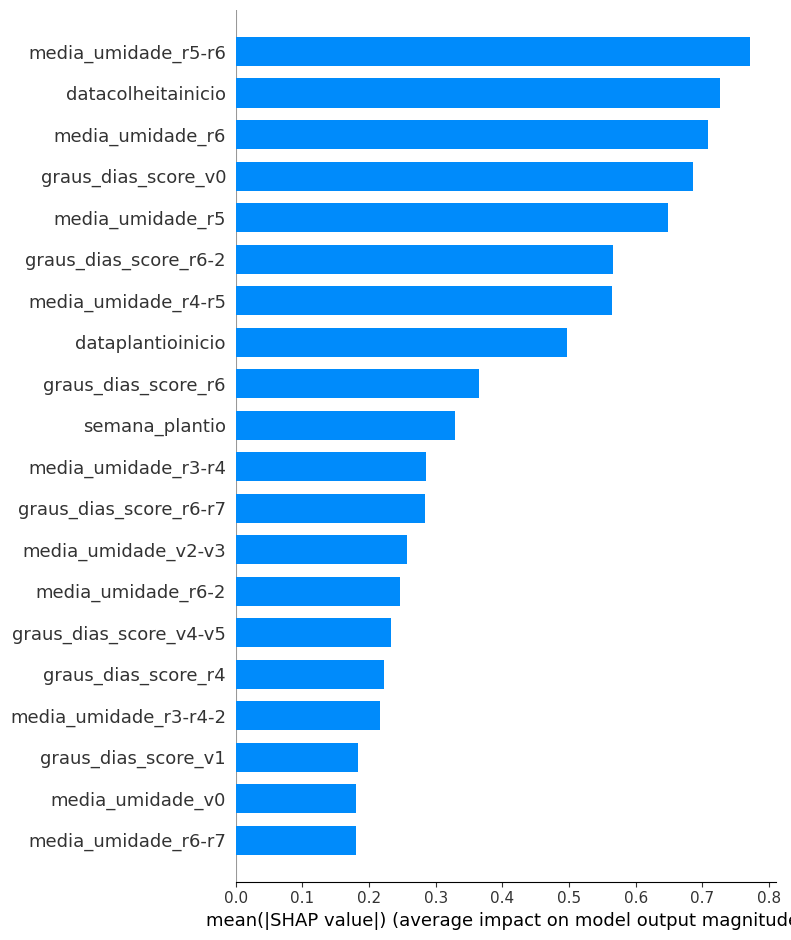

In [9]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(opt.model.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [79]:
data = pd.read_csv('data/csv/23_05_2024.csv')

#eliminando outliers pelo metodo interquartil baseado em produtividade
# Q1 = data['produtividade'].quantile(0.25)
# Q3 = data['produtividade'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[~((data['produtividade'] < (Q1 - 1.5 * IQR)) |(data['produtividade'] > (Q3 + 1.5 * IQR)))]

#concatenar safra com setor
data['safra_setor'] = data['safra'] + data['setor']
#calculando o std de produtividade para cada setor_safra
std_produtividade = data.groupby('safra_setor')['produtividade'].std().reset_index()
std_produtividade.columns = ['safra_setor', 'std_produtividade']
maior_q_20 = std_produtividade[std_produtividade['std_produtividade'] >= 20]


In [76]:
#media de produtividade e soma chuva por setor
#criar novo df
data_sector = data.copy()
data_sector['safra_setor'] = data_sector['safra'] + data_sector['setor']
data_sector = data_sector.groupby('safra_setor').agg({'produtividade': 'mean', 'soma_chuva': 'sum'}).reset_index()
data_sector.columns = ['safra_setor', 'media_produtividade', 'soma_chuva']
data_sector

,safra_setor,media_produtividade,soma_chuva
0,Safra 21/22Flor do Campo,46.310000,198.8
1,Safra 21/22INDEPENDÊNCIA,62.624643,4964.6
2,Safra 21/22NOVA,55.040000,1331.6
3,Safra 21/22Primavera,42.660000,305.0
4,Safra 21/22Região Rio Juruena,55.580000,5.2
...,...,...,...
64,Safra 23/24São Domingos,41.913258,3103.8
65,Safra 23/24Tanguro,36.867863,32856.6
66,Safra 23/24Triângulo,36.950950,6268.3
67,Safra 23/24Tucunaré 1,54.261320,33663.7


In [80]:
data[(data['setor'] == 'Região Rio Juruena') & (data['safra'] == 'Safra 21/22')]

,fazenda,setor,talhao,talhaoid,safra,safra_periodo,ocupacao,textura,dataemergencia,dataplantioinicio,...,soma_chuva_score,score_semanal,dias_para_soma,media_temperatura,media_radiacao_solar,media_umidade,herbicidas,inseticidas,fungicidas,safra_setor
20191,Agua Quente,Região Rio Juruena,19,2FCD0000-CF2F-DECA-C51F-08DB1B2F7DA0,Safra 21/22,Soja CV Safra 21/22,Soja,1. Arenosa (até 15%),2021-10-01,2021-09-20,...,-3.538462,95.901445,108,24.498715,59.69592,85.441979,17.0,15.0,7.0,Safra 21/22Região Rio Juruena


In [81]:
pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [93]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from IPython.display import display

nasa_csv = pd.read_csv('POWER_Regional_Daily_20240101_20240525.csv')
nasa_csv = nasa_csv[nasa_csv['DOY'] == 1]

lat = nasa_csv['LAT']
lon = nasa_csv['LON']
insolacao = nasa_csv['ALLSKY_SFC_SW_DWN']

# Criar o DataFrame
df = pd.DataFrame({
    'LAT': lat,
    'LON': lon,
    'INSOLACAO': insolacao
})

# Normalizar os valores de insolação para [0, 1]
norm = mcolors.Normalize(vmin=df['INSOLACAO'].min(), vmax=df['INSOLACAO'].max())
cmap = plt.get_cmap('coolwarm')

# Criar o mapa base
mapa = folium.Map(location=[df['LAT'].mean(), df['LON'].mean()], zoom_start=6)

# Adicionar grades no mapa
for _, row in df.iterrows():
    color = cmap(norm(row['INSOLACAO']))
    folium.Circle(
        location=[row['LAT'], row['LON']],
        radius=5000,  # raio de 5km
        color=mcolors.rgb2hex(color),
        fill=True,
        fill_color=mcolors.rgb2hex(color),
        fill_opacity=0.7
    ).add_to(mapa)

# Coordenadas da área demarcada em formato GeoJSON
area_demarcada = {
    "type": "Polygon",
    "coordinates": [[
        [-57.864119919117627, -14.304681623674306],
        [-57.846021602869271, -14.300621726797928],
        [-57.847471669709464, -14.29177001201376],
        [-57.865781686363547, -14.294533312651108],
        [-57.864119919117627, -14.304681623674306]
    ]]
}

# Adicionar a área demarcada ao mapa
folium.GeoJson(
    area_demarcada,
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'green',
        'weight': 2,
        'fillOpacity': 0.3,
    }
).add_to(mapa)

# Exibir o mapa
mapa.save('mapa_insolacao.html')
mapa

In [94]:
import folium

# Coordenadas do GeoJSON
area_demarcada = {
    "type": "Polygon",
    "coordinates": [[
        [-57.864119919117627, -14.304681623674306],
        [-57.846021602869271, -14.300621726797928],
        [-57.847471669709464, -14.29177001201376],
        [-57.865781686363547, -14.294533312651108],
        [-57.864119919117627, -14.304681623674306]
    ]]
}

# Extrair coordenadas do primeiro ponto do polígono
centroid_lat = area_demarcada['coordinates'][0][0][1]
centroid_lon = area_demarcada['coordinates'][0][0][0]

# Criar um mapa centrado nas coordenadas do ponto do polígono
m = folium.Map(location=[centroid_lat, centroid_lon], zoom_start=12)

# Adicionar a camada GeoJSON ao mapa
folium.GeoJson(area_demarcada).add_to(m)

# Exibir o mapa
m

In [88]:
nasa_csv

,LAT,LON,YEAR,DOY,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI
0,-20.75,-50.75,2024,1,21.55,29.74,13.56
1,-20.75,-50.25,2024,1,21.55,29.74,13.56
2,-20.75,-49.75,2024,1,16.50,29.62,7.27
3,-20.75,-49.25,2024,1,16.50,29.62,7.27
4,-20.75,-48.75,2024,1,14.05,29.69,5.29
...,...,...,...,...,...,...,...
15763,-16.75,-47.25,2024,146,18.16,18.86,-999.00
15764,-16.75,-46.75,2024,146,16.70,-999.00,-999.00
15765,-16.75,-46.25,2024,146,16.70,-999.00,-999.00
15766,-16.75,-45.75,2024,146,17.40,-999.00,-999.00


In [23]:
import warnings
import pandas as pd
import os
from config import Config
from utils.query_execution import create_dataframe_from_query


periodos = Config.combinacoes

def load_create_data(query_name):
    csv_filepath = f'data/csv/{query_name}.csv'
    try:
        if not os.path.exists(csv_filepath):
            data = create_dataframe_from_query(f'data/queries/{query_name}.sql')
            data.to_csv(csv_filepath, index=False)
        else:
            print(f"Arquivo {csv_filepath} já existe.")
            data = pd.read_csv(csv_filepath)
        return data
    except Exception as e:
        print(f"Erro ao criar o arquivo csv: {e}")


warnings.filterwarnings("ignore", category=RuntimeWarning)

query_name = '23_05_2024'
data = load_create_data(query_name)

Arquivo data/csv/23_05_2024.csv já existe.


In [14]:
data

,fazenda,setor,talhao,talhaoid,safra,safra_periodo,ocupacao,textura,dataemergencia,dataplantioinicio,...,chuva_esperada,soma_chuva_score,score_semanal,dias_para_soma,media_temperatura,media_radiacao_solar,media_umidade,herbicidas,inseticidas,fungicidas
0,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,0.0,0.000000,98.933902,46,27.131419,57.368411,61.254609,10.0,4.0,2.0
1,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,101.9,-3.095000,98.933902,51,24.063650,39.441036,84.190028,10.0,4.0,2.0
2,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,26.8,0.000000,98.933902,54,26.056510,60.454653,65.231615,10.0,4.0,2.0
3,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,26.5,0.236185,98.933902,62,23.122205,57.357407,86.019745,10.0,4.0,2.0
4,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,45.9,-0.185714,98.933902,66,24.206510,45.908281,89.323802,10.0,4.0,2.0
5,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,42.0,0.780669,98.933902,70,23.871120,47.639349,88.257461,10.0,4.0,2.0
6,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,86.3,0.713223,98.933902,80,23.197345,36.113844,91.325073,10.0,4.0,2.0
7,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,67.0,0.085714,98.933902,86,23.856250,86.914549,89.632040,10.0,4.0,2.0
8,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,96.5,0.756443,98.933902,94,23.227939,59.312154,90.498195,10.0,4.0,2.0
9,Agua Quente,Arrendamento Ughini's,86,DD250000-0C0F-D60B-CA2E-08DB1B2F82BF,Safra 22/23,Soja iPRO Safra 22/23,Soja,3. Media Argiloso (25~40%),2022-10-11,2022-10-06,...,62.8,0.786967,98.933902,101,24.372254,47.270387,83.927128,10.0,4.0,2.0


In [11]:
data = data[data['talhaoid'] == 'DD250000-0C0F-D60B-CA2E-08DB1B2F82BF']

In [52]:
from itertools import combinations

lista = ['r1-r2', 'r2-r3', 'r3', 'r3-r4', 'r3-r4-2', 'r4', 'r4-r5', 'r5', 'r5-r6', 'r6', 'r6-2', 'r6-r7']

combinacoes_3 = []

for i in range(len(lista)):
    for j in range(i+1, len(lista)):
        for k in range(j+1, len(lista)):
            combinacoes_3.append([lista[i], lista[j], lista[k]])

print(combinacoes_3)


[['r1-r2', 'r2-r3', 'r3'], ['r1-r2', 'r2-r3', 'r3-r4'], ['r1-r2', 'r2-r3', 'r3-r4-2'], ['r1-r2', 'r2-r3', 'r4'], ['r1-r2', 'r2-r3', 'r4-r5'], ['r1-r2', 'r2-r3', 'r5'], ['r1-r2', 'r2-r3', 'r5-r6'], ['r1-r2', 'r2-r3', 'r6'], ['r1-r2', 'r2-r3', 'r6-2'], ['r1-r2', 'r2-r3', 'r6-r7'], ['r1-r2', 'r3', 'r3-r4'], ['r1-r2', 'r3', 'r3-r4-2'], ['r1-r2', 'r3', 'r4'], ['r1-r2', 'r3', 'r4-r5'], ['r1-r2', 'r3', 'r5'], ['r1-r2', 'r3', 'r5-r6'], ['r1-r2', 'r3', 'r6'], ['r1-r2', 'r3', 'r6-2'], ['r1-r2', 'r3', 'r6-r7'], ['r1-r2', 'r3-r4', 'r3-r4-2'], ['r1-r2', 'r3-r4', 'r4'], ['r1-r2', 'r3-r4', 'r4-r5'], ['r1-r2', 'r3-r4', 'r5'], ['r1-r2', 'r3-r4', 'r5-r6'], ['r1-r2', 'r3-r4', 'r6'], ['r1-r2', 'r3-r4', 'r6-2'], ['r1-r2', 'r3-r4', 'r6-r7'], ['r1-r2', 'r3-r4-2', 'r4'], ['r1-r2', 'r3-r4-2', 'r4-r5'], ['r1-r2', 'r3-r4-2', 'r5'], ['r1-r2', 'r3-r4-2', 'r5-r6'], ['r1-r2', 'r3-r4-2', 'r6'], ['r1-r2', 'r3-r4-2', 'r6-2'], ['r1-r2', 'r3-r4-2', 'r6-r7'], ['r1-r2', 'r4', 'r4-r5'], ['r1-r2', 'r4', 'r5'], ['r1-r2', 'r4'

[['r1-r2', 'r2-r3', 'r3', 'r3-r4'], ['r1-r2', 'r2-r3', 'r3', 'r3-r4-2'], ['r1-r2', 'r2-r3', 'r3', 'r4'], ['r1-r2', 'r2-r3', 'r3', 'r4-r5'], ['r1-r2', 'r2-r3', 'r3', 'r5'], ['r1-r2', 'r2-r3', 'r3', 'r5-r6'], ['r1-r2', 'r2-r3', 'r3', 'r6'], ['r1-r2', 'r2-r3', 'r3', 'r6-2'], ['r1-r2', 'r2-r3', 'r3', 'r6-r7'], ['r1-r2', 'r2-r3', 'r3-r4', 'r3-r4-2'], ['r1-r2', 'r2-r3', 'r3-r4', 'r4'], ['r1-r2', 'r2-r3', 'r3-r4', 'r4-r5'], ['r1-r2', 'r2-r3', 'r3-r4', 'r5'], ['r1-r2', 'r2-r3', 'r3-r4', 'r5-r6'], ['r1-r2', 'r2-r3', 'r3-r4', 'r6'], ['r1-r2', 'r2-r3', 'r3-r4', 'r6-2'], ['r1-r2', 'r2-r3', 'r3-r4', 'r6-r7'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r4'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r4-r5'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r5'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r5-r6'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r6'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r6-2'], ['r1-r2', 'r2-r3', 'r3-r4-2', 'r6-r7'], ['r1-r2', 'r2-r3', 'r4', 'r4-r5'], ['r1-r2', 'r2-r3', 'r4', 'r5'], ['r1-r2', 'r2-r3', 'r4', 'r5-r6'], ['r1-r2', 'r2-r3', 'r4',

495

In [14]:
from config import Config

periodos = Config.combinacoes
periodos

for comb in periodos:
    data = data[data['estadio'].isin(comb)]
    print(f"Combinação: {comb}")
    print(data.shape)

Combinação: ['r1-r2', 'r3-r4', 'r4-r5']
(0, 34)
Combinação: ['r1-r2', 'r3-r4', 'r5']
(0, 34)
Combinação: ['r1-r2', 'r3-r4', 'r5-r6']
(0, 34)
Combinação: ['r1-r2', 'r3-r4-2', 'r4-r5']
(0, 34)
Combinação: ['r1-r2', 'r3-r4-2', 'r5']
(0, 34)
Combinação: ['r1-r2', 'r3-r4-2', 'r5-r6']
(0, 34)
Combinação: ['r1-r2', 'r4', 'r4-r5']
(0, 34)
Combinação: ['r1-r2', 'r4', 'r5']
(0, 34)
Combinação: ['r1-r2', 'r4', 'r5-r6']
(0, 34)
Combinação: ['r2-r3', 'r3-r4', 'r5']
(0, 34)
Combinação: ['r2-r3', 'r3-r4', 'r5-r6']
(0, 34)
Combinação: ['r2-r3', 'r3-r4-2', 'r4-r5']
(0, 34)
Combinação: ['r2-r3', 'r3-r4-2', 'r5']
(0, 34)
Combinação: ['r2-r3', 'r3-r4-2', 'r5-r6']
(0, 34)
Combinação: ['r2-r3', 'r4', 'r4-r5']
(0, 34)
Combinação: ['r2-r3', 'r4', 'r5']
(0, 34)
Combinação: ['r2-r3', 'r4', 'r5-r6']
(0, 34)
Combinação: ['r3', 'r3-r4', 'r4-r5']
(0, 34)
Combinação: ['r3', 'r3-r4', 'r5']
(0, 34)
Combinação: ['r3', 'r3-r4', 'r5-r6']
(0, 34)
Combinação: ['r3', 'r3-r4-2', 'r4-r5']
(0, 34)
Combinação: ['r3', 'r3-r4-2',

In [10]:
data['estadio'].value_counts()

estadio
r5       1728
r3-r4    1717
r2-r3    1716
Name: count, dtype: int64

In [19]:
import os
import joblib
import warnings
from datetime import date
from sklearn.model_selection import train_test_split
#custom
from models.select_models import select_model
from utils.query_execution import create_dataframe_from_query
from utils.dataprep import prepare_data, lag_variable, make_directories, select_types_from_data, normalize_data, convert_date_to_dayofyear
from utils.plot_models import plot_prediction

# carregando dados
data = create_dataframe_from_query("data/queries/novo_scores.sql")
data = data[data['ocupacao'] == 'Algodão']
# data = data[(data['produtividade'] < 80) & (data['produtividade'] > 35)]
data.dropna(inplace=True)

columns_to_drop = ['emergencia_colheita', 'datacolheitainicio','soma_chuva_score','chuva_esperada','graus_dias_esperado','ocupacao','setor','safra','safra_periodo','ano','dataemergencia','duracao_safra', 'periodo', 'media_velocidade_vento', 'media_direcao_vento', 'media_velocidade_rajada', 'media_direcao_rajada']
categorical_data = ['estadio', 'fazenda', 'talhao', 'textura']
target = 'produtividade'

dates = ['dataemergencia', 'datacolheitainicio', 'dataplantioinicio']
data = convert_date_to_dayofyear(data, dates)

#preparando dados
X, Y = prepare_data(data=data,
                    target=target,
                    drop_columns=columns_to_drop, 
                    categorical_columns= categorical_data)
make_directories()
dense_data, sparse_data = select_types_from_data(X)

models = ['xgboost']
scalers = ['standard']

print(X.info())

warnings.filterwarnings("ignore", category=RuntimeWarning)
if __name__ == '__main__':
    for scaler in scalers:
        metrics_dict = {}
        models_r2 = []
        
        normalized_data = normalize_data(X, scaler, sparse_data=sparse_data, dense_data=dense_data)
        x_train, x_test, y_train, y_test = train_test_split(normalized_data, Y, test_size=0.2, random_state=42)
        x_train.set_index('talhaoid', inplace=True)
        x_test.set_index('talhaoid', inplace=True)
        
        for model in models:
            print(f"Training {model} model")
            optimizer = select_model(model)
            optimizer.optimize(x_train, y_train)
            pred_x = optimizer.model.predict(x_test)
            
            #salvando o modelo
            data_atual = date.today().strftime("%d-%m-%Y")
            if not os.path.exists(f'saves/{data_atual}'):
                os.makedirs(f'saves/{date.today().strftime("%d-%m-%Y")}')
            
            best_model = optimizer.model.best_estimator_
            
            model_filename = f'saves/{data_atual}/{model}_model.pkl'
            joblib.dump(best_model, model_filename)

<class 'pandas.core.frame.DataFrame'>
Index: 4806 entries, 1338 to 33732
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   talhao                              4806 non-null   int32  
 1   talhaoid                            4806 non-null   object 
 2   dataplantioinicio                   4806 non-null   int32  
 3   estadio                             4806 non-null   int32  
 4   numero_estadio                      4806 non-null   int64  
 5   graus_dias                          4806 non-null   float64
 6   soma_graus_dias_acumulado           4806 non-null   float64
 7   graus_dias_score                    4806 non-null   float64
 8   soma_chuva                          4806 non-null   float64
 9   media_temperatura                   4806 non-null   float64
 10  media_radiacao_solar                4806 non-null   float64
 11  media_umidade                       4806 non

In [3]:
import joblib

normalized_data = normalize_data(X, 'standard', sparse_data=sparse_data, dense_data=dense_data)
x_train, x_test, y_train, y_test = train_test_split(normalized_data, Y, test_size=0.2, random_state=42)
x_train.set_index('talhaoid', inplace=True)
x_test.set_index('talhaoid', inplace=True)
#carregando o modelo .pkl
model_filename = 'saves/best_model_09-05_solos/xgboost_model.pkl'
model = joblib.load(model_filename)

In [21]:
x_test.shape

(962, 19)

In [8]:
from utils.plot_models import plot_prediction
import pandas as pd
import joblib

scalers = ['standard']

#carregando csv
x_test = pd.read_csv('data/first_1000_normalized.csv')
y_test = pd.read_csv('data/first_1000_Y.csv')
x_test.set_index('talhaoid', inplace=True)

model = joblib.load('saves/17-05-2024/xgboost_model.pkl')

pred_y = model.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rmse = mean_squared_error(y_test, pred_y, squared=False)
r2 = r2_score(y_test, pred_y)
mae = mean_absolute_error(y_test, pred_y)

print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")

RMSE: 10.358518328161397
R2: 0.23178467189486252
MAE: 8.461131887054446


c:\Users\Caio~\Desktop\repositorios\produtividade\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [5]:
x_test['talhaoid']

0      2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8
1      2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8
2      2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8
3      2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8
4      2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8
                       ...                 
995    DD250000-0C0F-D60B-6C35-08DB1B2F82E2
996    DD250000-0C0F-D60B-6C35-08DB1B2F82E2
997    88270000-C2E3-2AF2-7A4C-08DB1B2F8235
998    88270000-C2E3-2AF2-7A4C-08DB1B2F8235
999    88270000-C2E3-2AF2-7A4C-08DB1B2F8235
Name: talhaoid, Length: 1000, dtype: object

In [15]:
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")

RMSE: 2.181270676924511
R2: 0.980693383575068
MAE: 1.0611066154910505


In [71]:
import pandas as pd


predictions_df = pd.DataFrame({'Predicted': pred_y, 'Actual': y_test})
print(predictions_df)


        Predicted    Actual
26723   49.332726   47.1800
13244   72.771576   78.4200
8149    52.791447   57.7400
24076  283.800079  285.3500
24994   38.988796   38.4900
...           ...       ...
11959   67.641861   69.1800
34301   65.563820   67.3200
9236    64.915314   66.3900
15140   32.286549   32.6200
37671   61.748528   59.3500

[5650 rows x 2 columns]


MAPE: 5.377044736431118


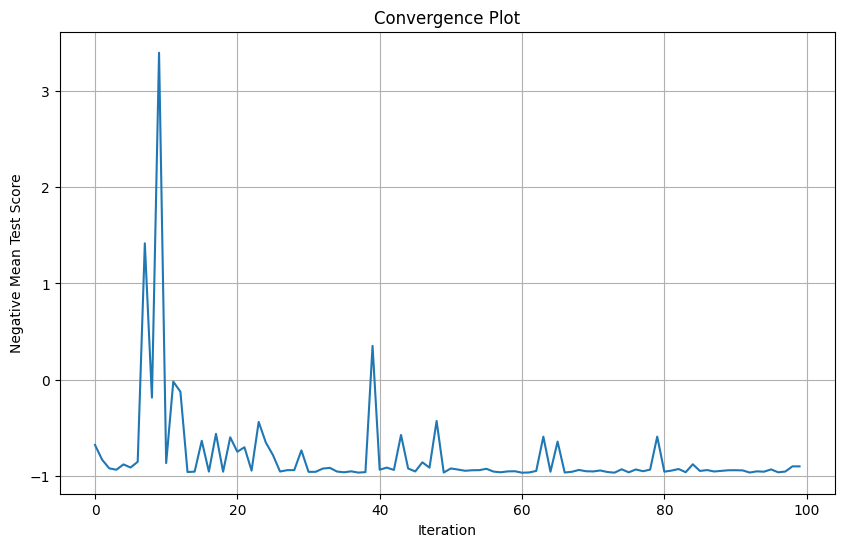

In [25]:
import matplotlib.pyplot as plt

def plot_convergence(searchcv):
    plt.figure(figsize=(10, 6))
    plt.plot(-searchcv.cv_results_['mean_test_score'])
    plt.xlabel('Iteration')
    plt.ylabel('Negative Mean Test Score')
    plt.title('Convergence Plot')
    plt.grid(True)
    plt.show()

plot_convergence(optimizer.model)

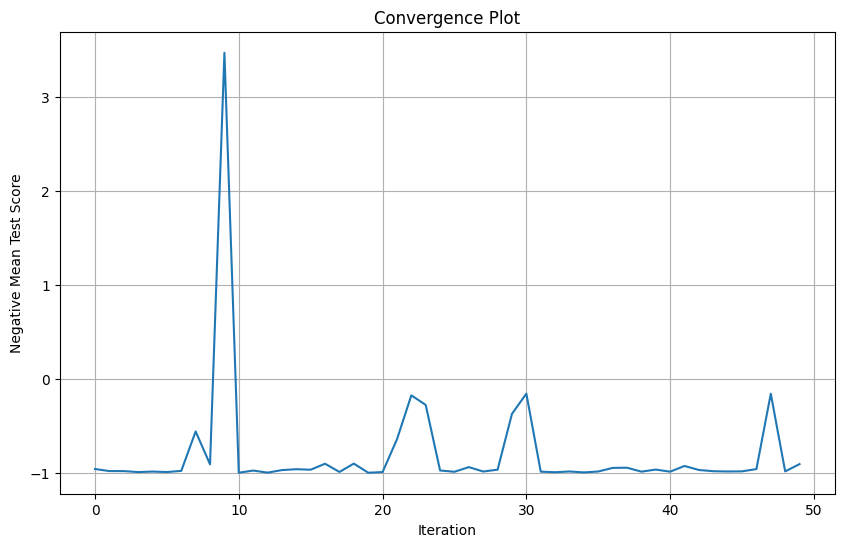

In [8]:
novo.dropna(inplace=True)
novo = novo[novo['ocupacao'] == 'Soja']
novo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22237 entries, 5 to 35802
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fazenda                  22237 non-null  object 
 1   setor                    22237 non-null  object 
 2   talhao                   22237 non-null  object 
 3   talhaoid                 22237 non-null  object 
 4   safra                    22237 non-null  object 
 5   safra_periodo            22237 non-null  object 
 6   ocupacao                 22237 non-null  object 
 7   dataemergencia           22237 non-null  object 
 8   dataplantioinicio        22237 non-null  object 
 9   datacolheitainicio       22237 non-null  object 
 10  ano                      22237 non-null  float64
 11  emergencia_colheita      22237 non-null  float64
 12  duracao_safra            22237 non-null  int64  
 13  periodo                  22237 non-null  int64  
 14  estadio                  22

In [55]:
import pandas as pd

datas = ['dataemergencia', 'datacolheitainicio', 'dataplantioinicio']
    
for data in datas:
    novo[data] = pd.to_datetime(novo[data])
    novo[data] = novo[data].dt.dayofyear

In [63]:
novo = pd.get_dummies(novo, columns=['estadio'])
novo_float = novo.select_dtypes(include=['float64', 'int64', 'bool']).columns

In [73]:
novo

,fazenda,setor,talhao,talhaoid,safra,safra_periodo,ocupacao,dataemergencia,dataplantioinicio,datacolheitainicio,...,estadio_r4,estadio_r4-r5,estadio_r5,estadio_r5-r6,estadio_r6,estadio_r6-r7,estadio_v0,estadio_v1,estadio_v2-v3,estadio_v4-v5
0,Agua Quente,Arrendamento Ughini's,83,2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8,Safra 22/23,Soja CV Safra 22/23,Soja,1.0,276,30,...,False,False,False,False,False,False,False,False,False,False
1,Agua Quente,Arrendamento Ughini's,83,2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8,Safra 22/23,Soja CV Safra 22/23,Soja,1.0,276,30,...,False,False,False,False,False,False,False,False,False,False
2,Agua Quente,Arrendamento Ughini's,83,2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8,Safra 22/23,Soja CV Safra 22/23,Soja,1.0,276,30,...,False,False,False,False,False,False,False,False,False,False
3,Agua Quente,Arrendamento Ughini's,83,2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8,Safra 22/23,Soja CV Safra 22/23,Soja,1.0,276,30,...,False,False,False,False,False,False,False,False,False,False
4,Agua Quente,Arrendamento Ughini's,83,2FCD0000-CF2F-DECA-23DB-08DB1B2F80C8,Safra 22/23,Soja CV Safra 22/23,Soja,1.0,276,30,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35886,Tucunare,Tucunaré 2,53,DD250000-0C0F-D60B-F72A-08DB1B2F82F5,Safra 22/23,Soja iPRO Safra 22/23,Soja,1.0,279,41,...,False,False,False,False,False,True,False,False,False,False
35887,Tucunare,Tucunaré 2,53,DD250000-0C0F-D60B-F72A-08DB1B2F82F5,Safra 22/23,Soja iPRO Safra 22/23,Soja,1.0,279,41,...,False,False,False,False,False,False,True,False,False,False
35888,Tucunare,Tucunaré 2,53,DD250000-0C0F-D60B-F72A-08DB1B2F82F5,Safra 22/23,Soja iPRO Safra 22/23,Soja,1.0,279,41,...,False,False,False,False,False,False,False,True,False,False
35889,Tucunare,Tucunaré 2,53,DD250000-0C0F-D60B-F72A-08DB1B2F82F5,Safra 22/23,Soja iPRO Safra 22/23,Soja,1.0,279,41,...,False,False,False,False,False,False,False,False,True,False


In [71]:
novo[novo_float].drop(columns = ['ano','dataemergencia','duracao_safra', 'periodo', 'media_velocidade_vento', 'media_direcao_vento', 'media_velocidade_rajada', 'media_direcao_rajada'])

,emergencia_colheita,soma_chuva,media_temperatura,graus_dias,media_radiacao_solar,media_umidade,estadio_r1-r2,estadio_r2-r3,estadio_r3,estadio_r3-r4,estadio_r4,estadio_r4-r5,estadio_r5,estadio_r5-r6,estadio_r6,estadio_r6-r7,estadio_v0,estadio_v1,estadio_v2-v3,estadio_v4-v5
0,113.0,1.4,25.878867,12.717500,52.935208,67.879271,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,113.0,20.6,25.258500,11.912000,47.914926,69.788302,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,113.0,2.2,23.861528,11.585000,43.961399,82.142882,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,113.0,117.8,23.492365,10.603333,56.436535,79.027678,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,113.0,51.8,23.656484,10.612500,46.785703,85.530430,False,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35886,121.0,375.8,23.871883,11.325926,36.801998,88.168646,False,False,False,False,False,False,False,False,False,True,False,False,False,False
35887,121.0,22.8,24.987965,12.698077,34.999109,75.749100,False,False,False,False,False,False,False,False,False,False,True,False,False,False
35888,121.0,99.8,24.435165,12.066667,61.876002,84.082847,False,False,False,False,False,False,False,False,False,False,False,True,False,False
35889,121.0,19.0,23.939811,11.124375,41.314401,82.403711,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [52]:
novo_data = novo['dataemergencia']
novo_data.unique

<bound method Series.unique of 0        282.0
1        282.0
2        282.0
3        282.0
4        282.0
         ...  
35886    285.0
35887    285.0
35888    285.0
35889    285.0
35890    285.0
Name: dataemergencia, Length: 35891, dtype: float64>

In [18]:
columns_num = data_index.select_dtypes(include=['float64', 'int64']).columns
columns_num = columns_num.drop(['decendios', 'numero_de_dias_agregados'])

In [19]:
columns_num

Index(['graus_dias', 'defict_hidrico', 'chuva', 'radiacao', 'umidade'], dtype='object')

In [20]:
from scipy.stats import shapiro

for column in columns_num:
    column_ob = data_index[column]
    stat, p_valor = shapiro(column_ob)
    print(f"Columna: {column}")
    if p_valor > 0.05:
        print("Distribuição é normal")
    else:
        print("Distribuição não é normal com p-valor: ", p_valor)

Columna: graus_dias
Distribuição não é normal com p-valor:  4.189377963066384e-83
Columna: defict_hidrico
Distribuição não é normal com p-valor:  2.909355358269881e-71
Columna: chuva
Distribuição não é normal com p-valor:  7.090263152217974e-73
Columna: radiacao
Distribuição não é normal com p-valor:  3.3629710585673806e-44
Columna: umidade
Distribuição não é normal com p-valor:  9.555772950540883e-56


c:\Users\Caio~\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17343.
  res = hypotest_fun_out(*samples, **kwds)


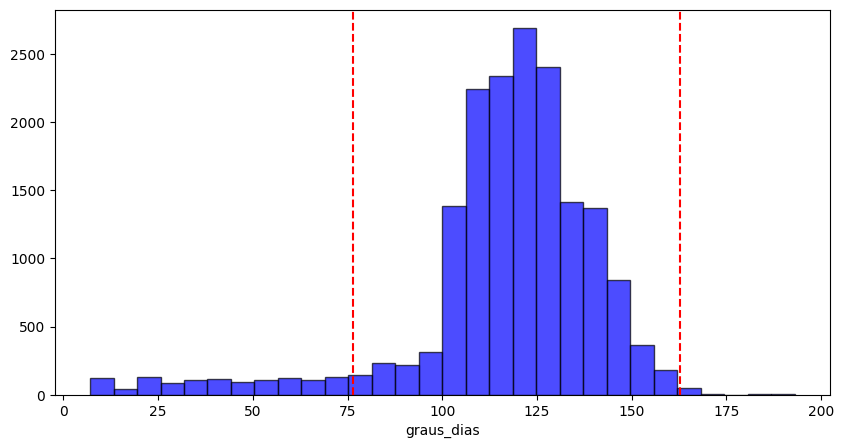

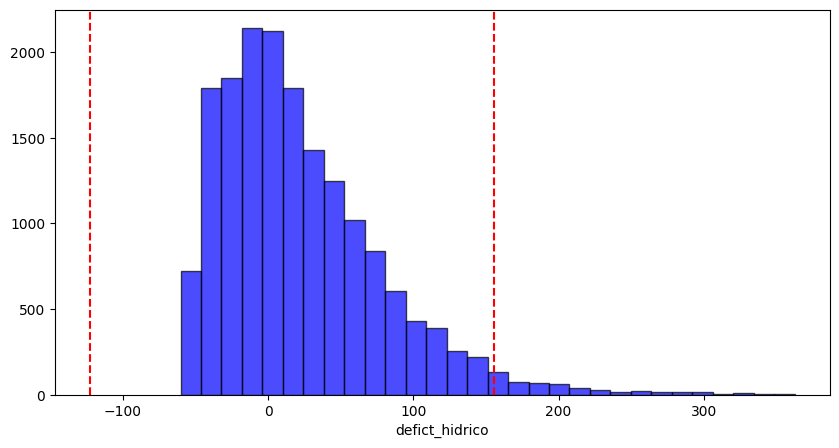

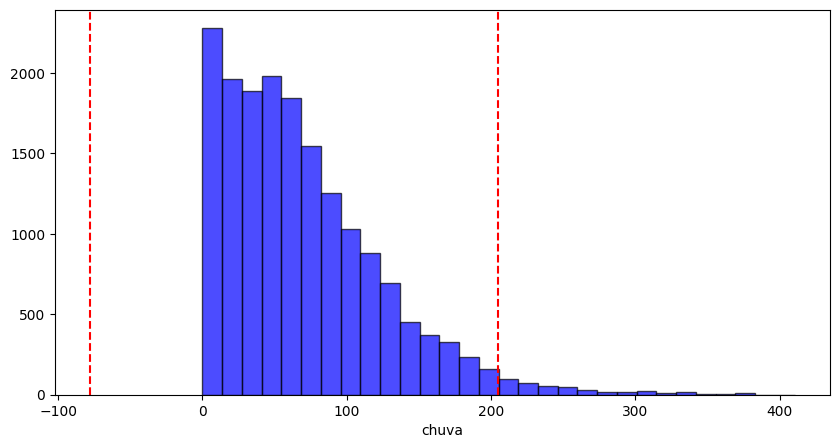

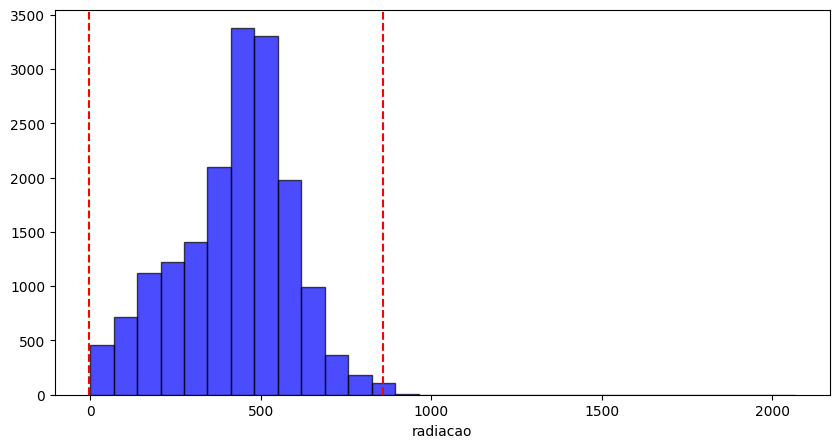

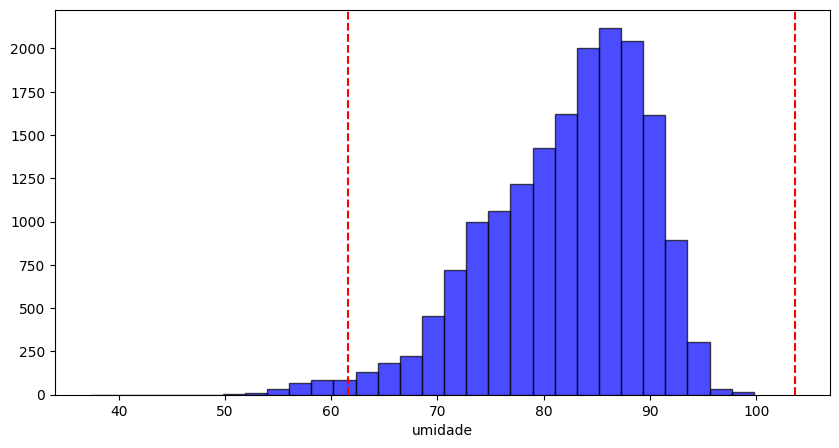

In [21]:
from matplotlib import pyplot as plt
import numpy as np

for column in columns_num:
    column_ob = data_index[column]
    Q1 = column_ob.quantile(0.25)
    Q3 = column_ob.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = column_ob[(column_ob < limite_inferior) | (column_ob > limite_superior)]
    plt.figure(figsize=(10, 5))
    plt.hist(column_ob, bins=30, color='blue', edgecolor='black', alpha=0.7)
    plt.axvline(limite_inferior, color='red', linestyle='--')
    plt.axvline(limite_superior, color='red', linestyle='--')
    plt.xlabel(column)
    plt.show()
    


In [11]:
produtividade = produtividade.astype(float)

In [29]:
Q1 = produtividade.quantile(0.25)
Q3 = produtividade.quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = produtividade[(produtividade < limite_inferior) | (produtividade > limite_superior)]

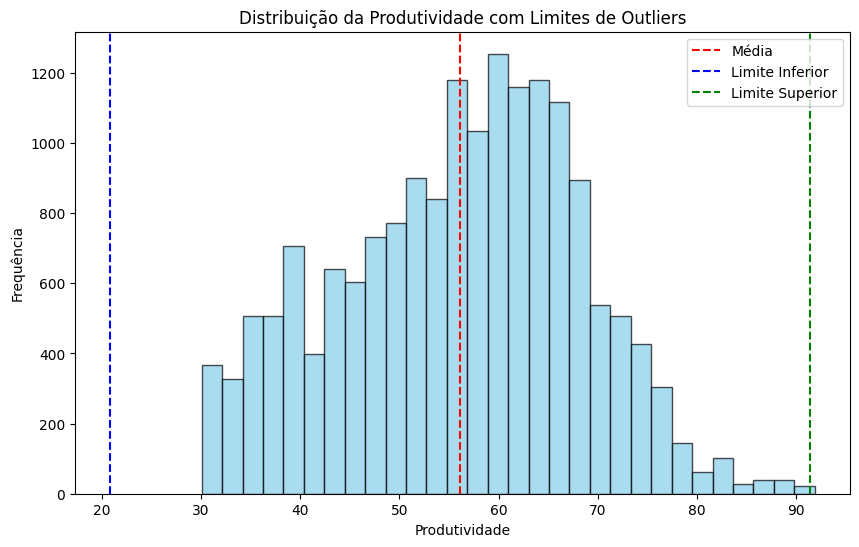

In [23]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(produtividade, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(np.mean(produtividade), color='red', linestyle='--', label='Média')
plt.axvline(limite_inferior, color='blue', linestyle='--', label='Limite Inferior')
plt.axvline(limite_superior, color='green', linestyle='--', label='Limite Superior')
plt.xlabel('Produtividade')
plt.ylabel('Frequência')
plt.title('Distribuição da Produtividade com Limites de Outliers')
plt.legend()
plt.show()

In [24]:
import numpy as np

media = produtividade.mean()
desvio_padrao = produtividade.std()

produtividade_zscore = (produtividade - media) / desvio_padrao

In [5]:
import pandas as pd

# Suponha que 'data' seja o seu DataFrame
for column in data_index.columns:
    if data_index[column].dtype == 'object':
        try:
            # Tenta converter os valores da coluna para float
            pd.to_numeric(data_index[column])
        except ValueError:
            print(f'A coluna {column} contém valores não numéricos.')


A coluna fazenda contém valores não numéricos.
A coluna setor contém valores não numéricos.
A coluna talhaoid contém valores não numéricos.
A coluna safra contém valores não numéricos.
A coluna safra_periodo contém valores não numéricos.
A coluna cultura contém valores não numéricos.
A coluna tecnologia contém valores não numéricos.
A coluna variedade contém valores não numéricos.
A coluna texturasolo contém valores não numéricos.


In [24]:
data_index = data_index.drop(columns = columns_to_drop)
dados_float = data_index.select_dtypes(include=['float64', 'int64']).columns
# dados_float_df = data_index[dados_float].drop(columns = ['decendios', 'numero_de_dias_agregados'])
dados_float_df = data_index[dados_float]
dados_float_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22360 entries, 10 to 26572
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   emergencia_colheita        22360 non-null  float64
 1   numero_estadio             22360 non-null  int64  
 2   graus_dias                 22360 non-null  float64
 3   soma_graus_dias_acumulado  22360 non-null  float64
 4   graus_dias_score           22360 non-null  float64
 5   soma_chuva                 22360 non-null  float64
 6   media_temperatura          22360 non-null  float64
 7   media_radiacao_solar       22360 non-null  float64
 8   media_umidade              22360 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.7 MB


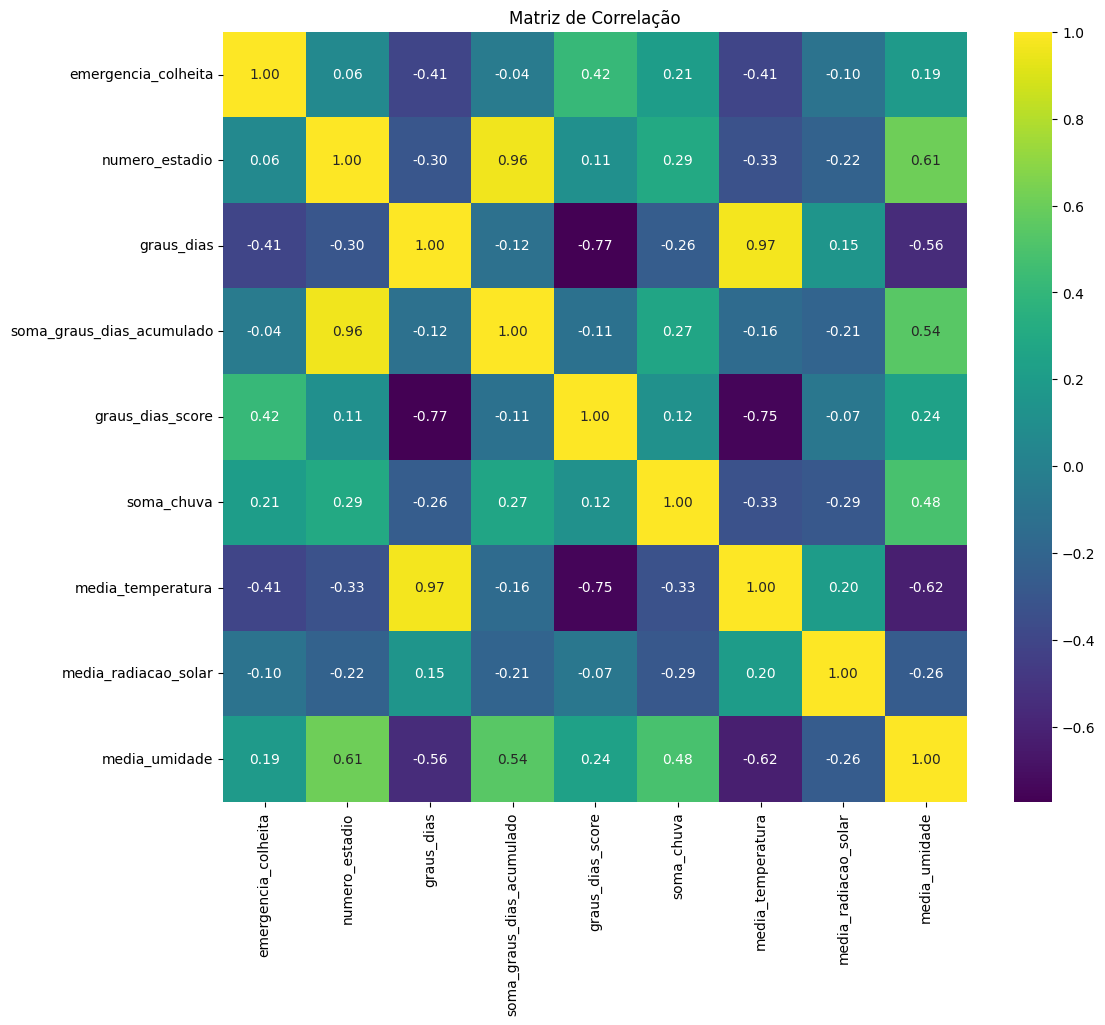

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# dummy_variables = pd.get_dummies(data_index['texturasolo'], prefix='texturasolo')
# data_with_dummies = pd.concat([data_index[['graus_dias', 'defict_hidrico', 'chuva', 'radiacao', 'umidade', 'numero_de_dias_agregados', 'ndvi_avg', 'ndvi_max', 'ndvi_min', 'ndre_avg', 'ndre_max', 'ndre_min', 'produtividade']], dummy_variables], axis=1)

# selected_columns = ['graus_dias', 'chuva', 'radiacao', 'umidade', 'ndvi_avg', 'produtividade']
correlation_matrix = dados_float_df.corr(method='spearman')

# Plotar a matriz de correlação como um mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", annot_kws={'size': 10})
plt.title('Matriz de Correlação')
plt.show()


In [27]:
data_index['numero_estadio'].min()

1

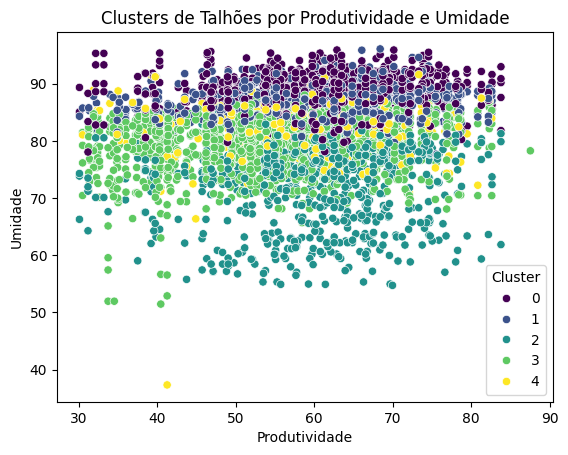

In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


features = ['graus_dias', 'chuva', 'radiacao', 'umidade', 'ndvi_avg']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_with_dummies[features])

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_k = silhouette_scores.index(max(silhouette_scores)) + 2 
kmeans = KMeans(n_clusters=best_k, random_state=42)
data_with_dummies['cluster'] = kmeans.fit_predict(scaled_data)

sns.scatterplot(data=data_with_dummies, x='produtividade', y='umidade', hue='cluster', palette='viridis')
plt.title('Clusters de Talhões por Produtividade e Umidade')
plt.xlabel('Produtividade')
plt.ylabel('Umidade')
plt.legend(title='Cluster')
plt.show()

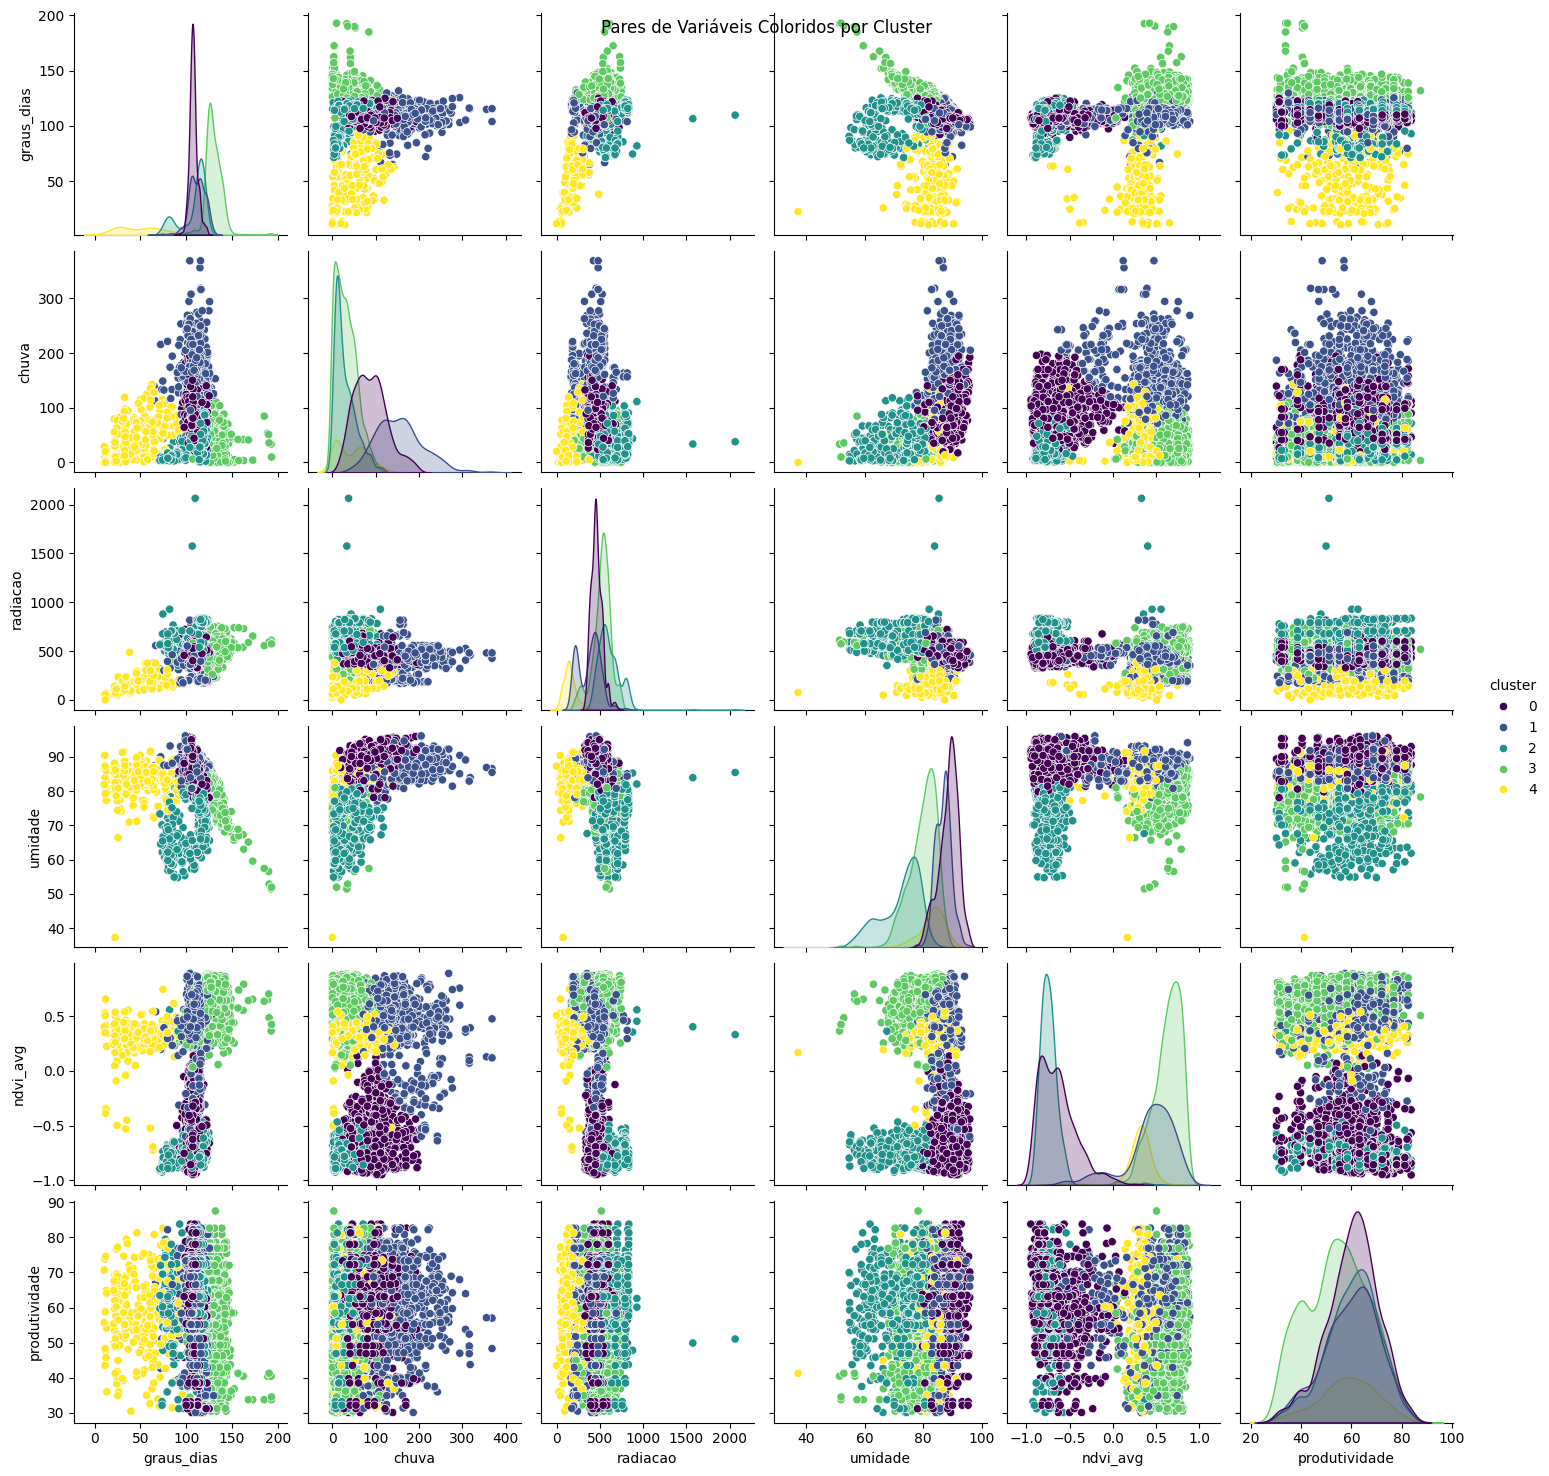

In [36]:
# #dropando variáveis
# data_with_dummies.drop(columns=dummy_variables.columns, inplace=True)
# data_with_dummies.drop(columns=['ndre_max', 'ndre_min', 'ndre_avg', 'ndvi_max', 'ndvi_min', 'numero_de_dias_agregados', 'defict_hidrico'], inplace=True)

sns.pairplot(data=data_with_dummies, hue='cluster', palette='viridis')
plt.suptitle('Pares de Variáveis Coloridos por Cluster')
plt.show()

In [ ]:
cluster_means = data_with_dummies.groupby('cluster').mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, cmap='viridis', annot=True, fmt=".2f")
plt.title('Médias das Variáveis por Cluster')
plt.xlabel('Variáveis')
plt.ylabel('Cluster')
plt.show()

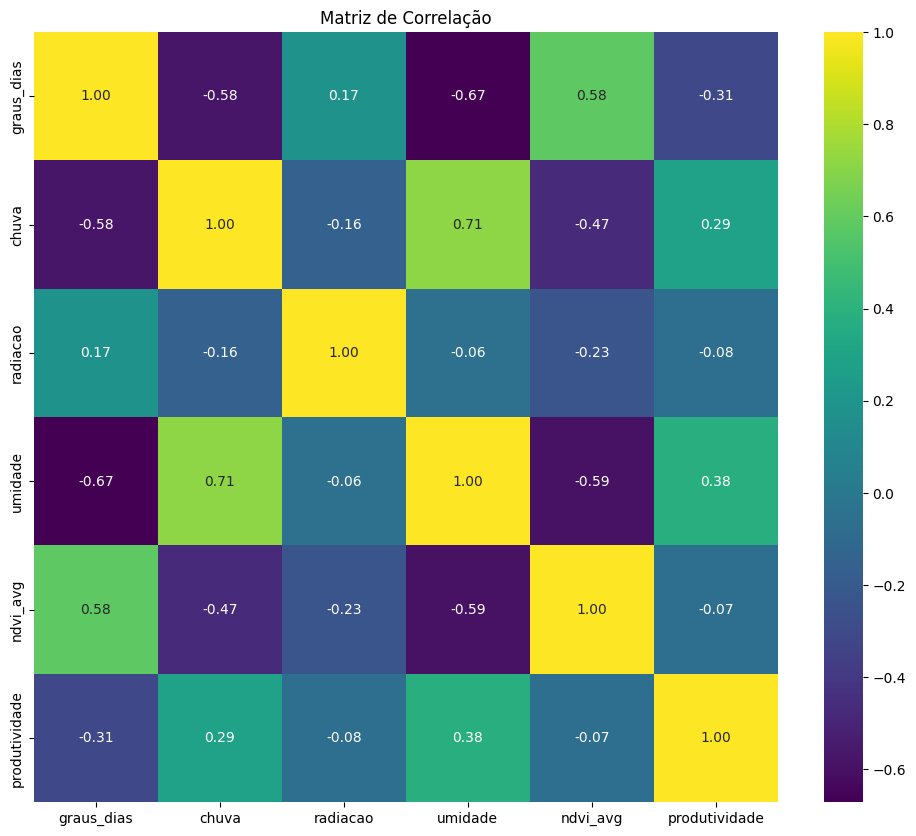

In [172]:
grouped_data = data_index.groupby('talhaoid')[selected_columns].mean()

# Calcular a matriz de correlação de Spearman
correlation_matrix = grouped_data[selected_columns].corr(method='spearman')

# Plotar a matriz de correlação como um mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", annot_kws={'size': 10})
plt.title('Matriz de Correlação')
plt.show()


In [163]:
data_with_dummies.columns

Index(['graus_dias', 'defict_hidrico', 'chuva', 'radiacao', 'umidade',
       'numero_de_dias_agregados', 'ndvi_avg', 'ndvi_max', 'ndvi_min',
       'ndre_avg', 'ndre_max', 'ndre_min', 'produtividade',
       'texturasolo_1. Arenosa (até 15%)',
       'texturasolo_2. Media Arenoso (15~25%)',
       'texturasolo_3. Media Argiloso (25~40%)',
       'texturasolo_4. Argiloso (40~60%)'],
      dtype='object')

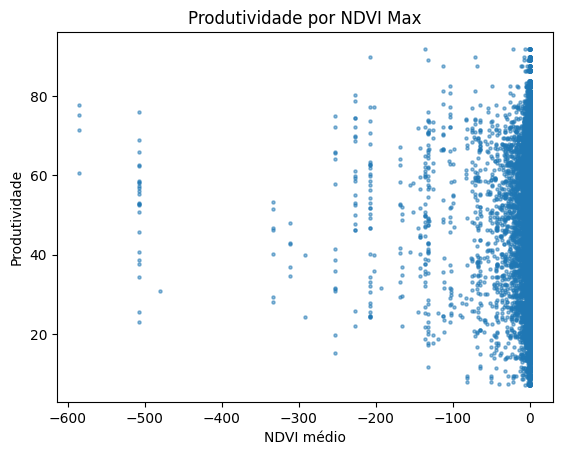

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(data_index['soma_chuva_score'], data_index['produtividade'], s=5, alpha=0.5)
plt.xlabel('NDVI médio')
plt.ylabel('Produtividade')
plt.title('Produtividade por NDVI Max')
plt.show()

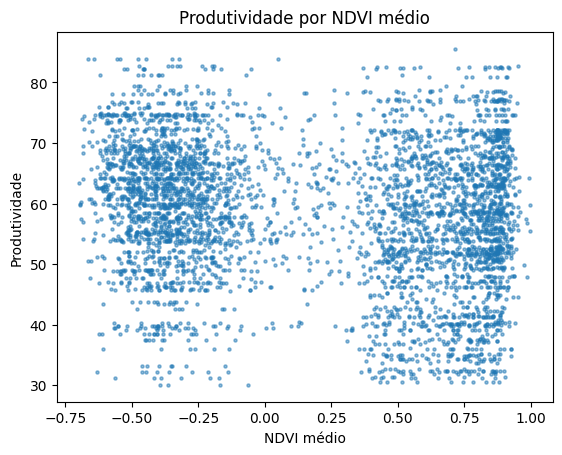

In [64]:
len(without_na['talhaoid'].unique())

583

In [37]:
data_without_nan = data_index.dropna(subset=['fazenda'])


(216501, 24)

In [50]:
data_index.info()   

<class 'pandas.core.frame.DataFrame'>
Index: 222384 entries, 143622 to 222383
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fazenda             216501 non-null  object 
 1   setor               216501 non-null  object 
 2   talhao              216501 non-null  object 
 3   talhaoid            216501 non-null  object 
 4   safra               216501 non-null  object 
 5   safra_periodo       216501 non-null  object 
 6   cultura             216501 non-null  object 
 7   chuva               216501 non-null  float64
 8   temperatura_media   216501 non-null  float64
 9   temperatura_min     216501 non-null  float64
 10  temperatura_max     216501 non-null  float64
 11  radiacao            173071 non-null  float64
 12  umidade             216501 non-null  float64
 13  data_leitura        216501 non-null  object 
 14  dataemergencia      216501 non-null  object 
 15  dataplantioinicio   216501 non-nul

In [46]:
data_index = data_index.sort_values(by='data_leitura')

# Calcule o máximo em uma janela de 30 dias para 'ndvi_avg' e preencha os valores NaN
data_index['ndvi_avg'] = data_index['ndvi_avg'].fillna(data_index['ndvi_avg'].rolling('30d').max())

ValueError: window must be an integer 0 or greater

In [49]:
data_index['data_leitura'].info()


<class 'pandas.core.series.Series'>
Index: 222384 entries, 143622 to 222383
Series name: data_leitura
Non-Null Count   Dtype 
--------------   ----- 
216501 non-null  object
dtypes: object(1)
memory usage: 3.4+ MB


In [44]:
len(data_index['ndvi_avg'].unique())

28155

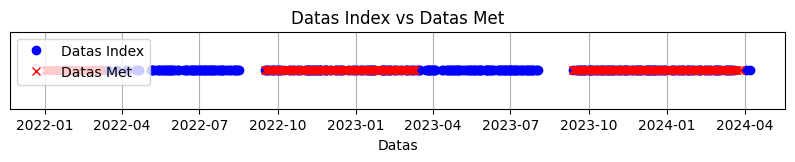

In [22]:
import matplotlib.pyplot as plt

datas_index = data_index['data_img'].unique()
datas_met = data_met['data_leitura'].unique()

tamanho_minimo = min(len(datas_index), len(datas_met))
datas_index = datas_index[:tamanho_minimo]
datas_met = datas_met[:tamanho_minimo]

valores = [1] * len(datas_index)

plt.figure(figsize=(10, 1))
plt.plot(datas_index, valores, 'bo', label='Datas Index')
plt.plot(datas_met, valores, 'rx', label='Datas Met')
plt.yticks([])  # Remover os valores do eixo Y
plt.xlabel('Datas')
plt.title('Datas Index vs Datas Met')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
iris_amp = mf.ampute_data(data_2,perc=0.25,random_state=1991)

In [27]:
from sklearn.impute import KNNImputer

In [29]:
data_2_teste = data_2["ndvi_avg"]

In [30]:
import miceforest as mf
import pandas as pd

df2 = data_2.copy()
impute = mf.ImputationKernel(data=data_2_teste,
save_all_iterations=True,
random_state=42
)
impute.mice(5)
impute.complete_data(0)
results = pd.concat([impute.complete_data(i) for i in range(5)]).groupby(level=0).mean()
results

ValueError: impute_data not recognized.

: 

In [6]:
##métodos de completar valores nan

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd

colunas_float64 = data.select_dtypes(include=['float64']).columns

data = data[colunas_float64]

imp = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0), random_state=0)
data_imputer = pd.DataFrame(imp.fit_transform(data), columns=colunas_float64)


c:\Users\Caio~\Desktop\repositorios\produtividade\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
data

,graus_dias,defict_hidrico,chuva,radiacao,umidade,ndvi_avg,ndvi_max,ndvi_min,ndre_avg,ndre_max,ndre_min
0,145.890,28.767625,83.8,425.911354,67.002750,NaN,NaN,NaN,NaN,NaN,NaN
1,132.025,7.186208,58.1,388.858834,80.224458,NaN,NaN,NaN,NaN,NaN,NaN
2,136.485,-51.506125,2.0,449.339583,72.056854,NaN,NaN,NaN,NaN,NaN,NaN
3,137.330,25.673750,78.7,430.109583,76.122021,NaN,NaN,NaN,NaN,NaN,NaN
4,123.775,3.396167,53.2,407.852067,85.514729,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19912,131.010,-52.353583,0.0,728.288750,77.204042,0.803585,0.866600,0.162458,0.665081,0.766973,0.120769
19913,127.095,-13.682375,37.1,549.001759,82.265771,0.735296,0.911887,0.266597,0.617882,0.780483,0.207509
19914,123.580,-18.438583,31.0,588.762604,84.721875,0.871875,0.939469,0.181832,0.726348,0.857146,0.130235
19915,130.215,-40.956333,10.0,582.631875,82.784896,0.732412,0.859814,0.124774,0.498487,0.685471,0.093333


In [10]:
data_imputer

,graus_dias,defict_hidrico,chuva,radiacao,umidade,ndvi_avg,ndvi_max,ndvi_min,ndre_avg,ndre_max,ndre_min
0,145.890,28.767625,83.8,425.911354,67.002750,0.296792,0.489624,-0.030140,0.238510,0.458640,-0.043836
1,132.025,7.186208,58.1,388.858834,80.224458,0.131905,0.406736,-0.162968,0.161810,0.425523,-0.188788
2,136.485,-51.506125,2.0,449.339583,72.056854,0.287717,0.489324,-0.052260,0.226838,0.417246,-0.095345
3,137.330,25.673750,78.7,430.109583,76.122021,0.247388,0.477174,-0.043731,0.201300,0.400073,-0.070736
4,123.775,3.396167,53.2,407.852067,85.514729,-0.276629,0.082083,-0.498929,0.014350,0.324080,-0.278259
...,...,...,...,...,...,...,...,...,...,...,...
19912,131.010,-52.353583,0.0,728.288750,77.204042,0.803585,0.866600,0.162458,0.665081,0.766973,0.120769
19913,127.095,-13.682375,37.1,549.001759,82.265771,0.735296,0.911887,0.266597,0.617882,0.780483,0.207509
19914,123.580,-18.438583,31.0,588.762604,84.721875,0.871875,0.939469,0.181832,0.726348,0.857146,0.130235
19915,130.215,-40.956333,10.0,582.631875,82.784896,0.732412,0.859814,0.124774,0.498487,0.685471,0.093333


In [26]:
import pandas as pd

data_talhaoid = data['talhaoid']
columns_to_drop = ['talhaoid','fazenda', 'setor', 'talhao', 'safra_periodo', 'safra','numero_de_dias_agregados', 'cultura', 'variedade', 'defict_hidrico', 'chuva', 'decendios']

data.drop(columns_to_drop, axis=1, inplace=True)
data['produtividade'] = data['produtividade'].astype(float)


object_data = data.select_dtypes(include=['object']).columns
#agrupando por talhaoid usando get_dummies em objects
data = pd.get_dummies(data, columns=object_data, dtype='int')
data.reset_index(drop=True, inplace=True)
data_talhaoid.reset_index(drop=True, inplace=True)
data = data.merge(data_talhaoid, left_index=True, right_index=True)

data.merge(data_talhaoid, left_index=True, right_index=True)
data.shape


(5373, 17)

In [27]:
from models.select_models import select_model
from sklearn.model_selection import cross_val_score
from utils.query_execution import create_dataframe_from_query
from utils.dataprep import prepare_data, split_and_normalize_data, lag_variable, make_directories
from utils.plot_models import plot_prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

scaler = 'standard'
target = 'produtividade'

#preparando dados
X, Y = prepare_data(data=data,
                    target=target,
                    drop_columns=[], 
                    categorical_columns= [])
dense_data = X.select_dtypes(include=['float64', 'int64']).columns
sparse_data = [col for col in X.columns if col not in dense_data]
bool_columns = X.select_dtypes(include=bool).columns
X[bool_columns] = X[bool_columns].astype(int)


In [28]:
x_train, x_test, y_train, y_test = split_and_normalize_data(X, Y, test_size=0.2, 
                                                                random_state=42, 
                                                                scaler=scaler, 
                                                                sparse_data=sparse_data, dense_data=dense_data)

In [31]:
x_train.set_index('talhaoid', inplace=True)
x_test.set_index('talhaoid', inplace=True)

In [32]:
model = 'xgboost'

optimizer = select_model(model)
optimizer.optimize(x_train, y_train)
pred_x = optimizer.model.predict(x_test)

In [35]:
best_model = optimizer.model.best_estimator_
cv_r2_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='r2', n_jobs=-1)
mean_cv_r2 = cv_r2_scores.mean()
print(f"Mean CV R2: {mean_cv_r2}")

Mean CV R2: 0.3328714775247909


In [54]:
import pandas as pd

object_data = data.select_dtypes(include=['object']).columns
#agrupando por talhaoid usando get_dummies em objects
data = pd.get_dummies(data, columns=object_data, dtype='int')
# data = data.merge(data_talhaoid, left_index=True, right_index=True)
# data_grouped = data.groupby('talhaoid').mean()
# data_grouped.reset_index(inplace=True)
data.merge(data_talhaoid, left_index=True, right_index=True)
data.shape

(5373, 16)

In [57]:
data_talhaoid.shape

(5373,)

In [5]:
dense_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [22]:
import pandas as pd
df = pd.get_dummies(data, columns=['tecnologia'], dtype=bool)

In [20]:
# Converte as colunas booleanas para tipo inteiro
bool_columns = df.select_dtypes(include=bool).columns
df[bool_columns] = df[bool_columns].astype(int)

In [7]:
df_pivot = data.pivot(index= data.index, columns='decendios', values=['umidade', 'ndvi_avg', 'ndre_avg', 'produtividade'])

# Renomeando as colunas pivotadas
df_pivot.columns = [f'{col[0]}_{col[1]}' for col in df_pivot.columns]

KeyError: 0

In [5]:
df_pivot

,umidade_1,umidade_2,umidade_3,umidade_4,umidade_5,umidade_6,umidade_7,umidade_8,umidade_9,umidade_10,...,produtividade_5,produtividade_6,produtividade_7,produtividade_8,produtividade_9,produtividade_10,produtividade_11,produtividade_12,produtividade_13,produtividade_14
0,74.568658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,73.649217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,79.099375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,81.220042,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,54.959854,NaN,NaN,NaN,NaN,NaN,...,69.6700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5368,NaN,NaN,NaN,NaN,NaN,75.850142,NaN,NaN,NaN,NaN,...,NaN,63.1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5369,NaN,NaN,NaN,NaN,NaN,NaN,77.024265,NaN,NaN,NaN,...,NaN,NaN,63.1200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.039878,NaN,NaN,...,NaN,NaN,NaN,63.1200,NaN,NaN,NaN,NaN,NaN,NaN
5371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.168914,NaN,...,NaN,NaN,NaN,NaN,63.1200,NaN,NaN,NaN,NaN,NaN


In [6]:
data.shape

(5373, 24)

In [27]:
data_dropado = data.dropna(inplace=True)

In [30]:
data.shape

(5373, 21)

In [31]:
textura_de_solo = data['texturasolo']
tecnologia = data['tecnologia']
produtividade = data['produtividade']
variedade = data['variedade']


frequencias_textura = textura_de_solo.value_counts()
frequencias_tecnologia = tecnologia.value_counts()
frequencias_variedade = variedade.value_counts()

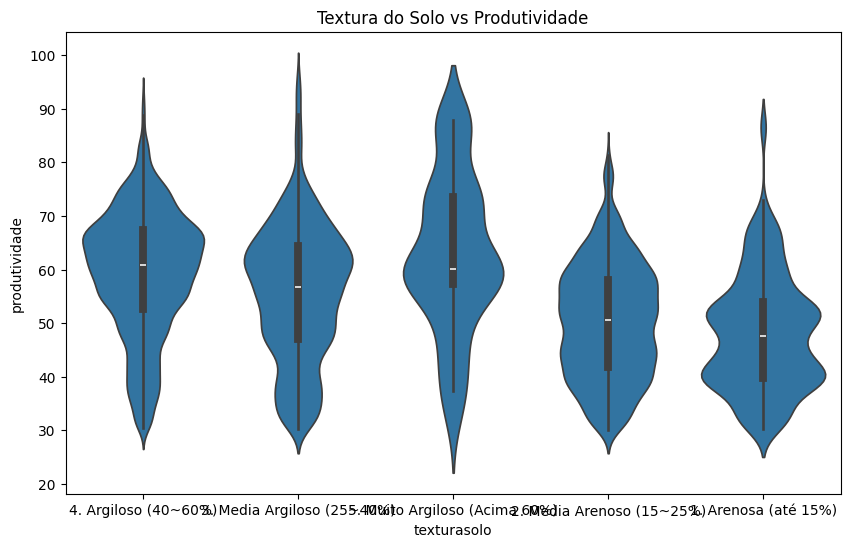

In [37]:
#plot de textura de solo em relação a produtividade
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x='texturasolo', y='produtividade', data=data)
plt.title('Textura do Solo vs Produtividade')
plt.show()


In [47]:
#desvio padrão da produtividade por textura de solo
std_produtividade = data.groupby('texturasolo')['produtividade'].std()
print(std_produtividade)
#desvio padrão da produtividade por tecnologia
std_produtividade = data.groupby('tecnologia')['produtividade'].std()
print(std_produtividade)
#desvio padrão da produtividade por variedade
std_produtividade = data.groupby('variedade')['produtividade'].std()
print(std_produtividade)


texturasolo
1. Arenosa (até 15%)             10.716039
2. Media Arenoso (15~25%)        10.686380
3. Media Argiloso (25~40%)       12.704279
4. Argiloso (40~60%)             11.647295
5. Muito Argiloso (Acima 60%)    14.501637
Name: produtividade, dtype: float64
tecnologia
Soja CV       9.429921
Soja RR       8.705565
Soja iPRO    13.313479
Name: produtividade, dtype: float64
variedade
6601 I2X C1          2.057301
67I68RSF IPRO C2    14.497635
67I68RSF IPRO S1    10.507279
67I68RSF IPRO S2    12.112941
68 XTD BA            0.000000
                      ...    
TMG4377 C2           8.857164
TMG4377 GE           1.014705
TMG4377 S1           7.447017
TMG7368IPRO C2       9.396761
TMG7368IPRO S1       0.000000
Name: produtividade, Length: 130, dtype: float64


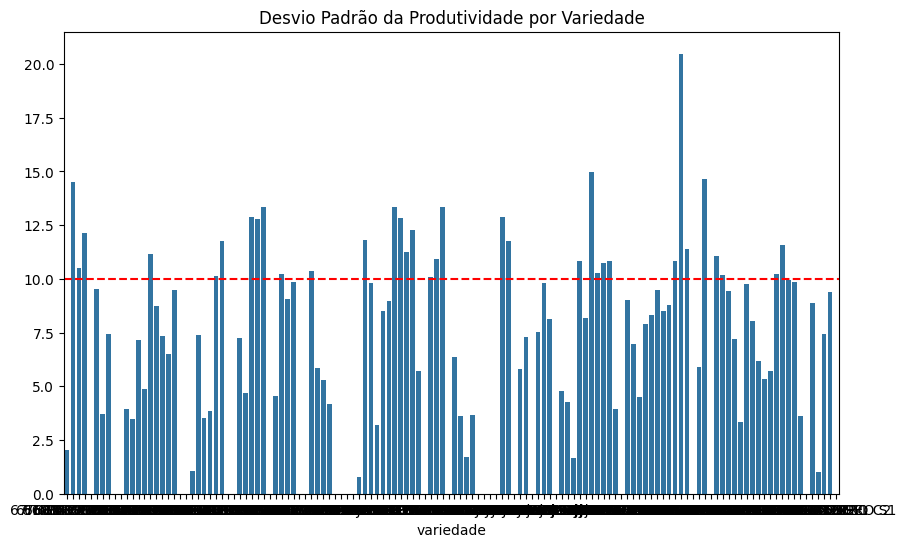

In [49]:
#plot do desvio padrão da produtividade por variedade
plt.figure(figsize=(10, 6))
sns.barplot(x=std_produtividade.index, y=std_produtividade.values)
plt.axhline(y=10, color='red', linestyle='--')
plt.title('Desvio Padrão da Produtividade por Variedade')
plt.show()

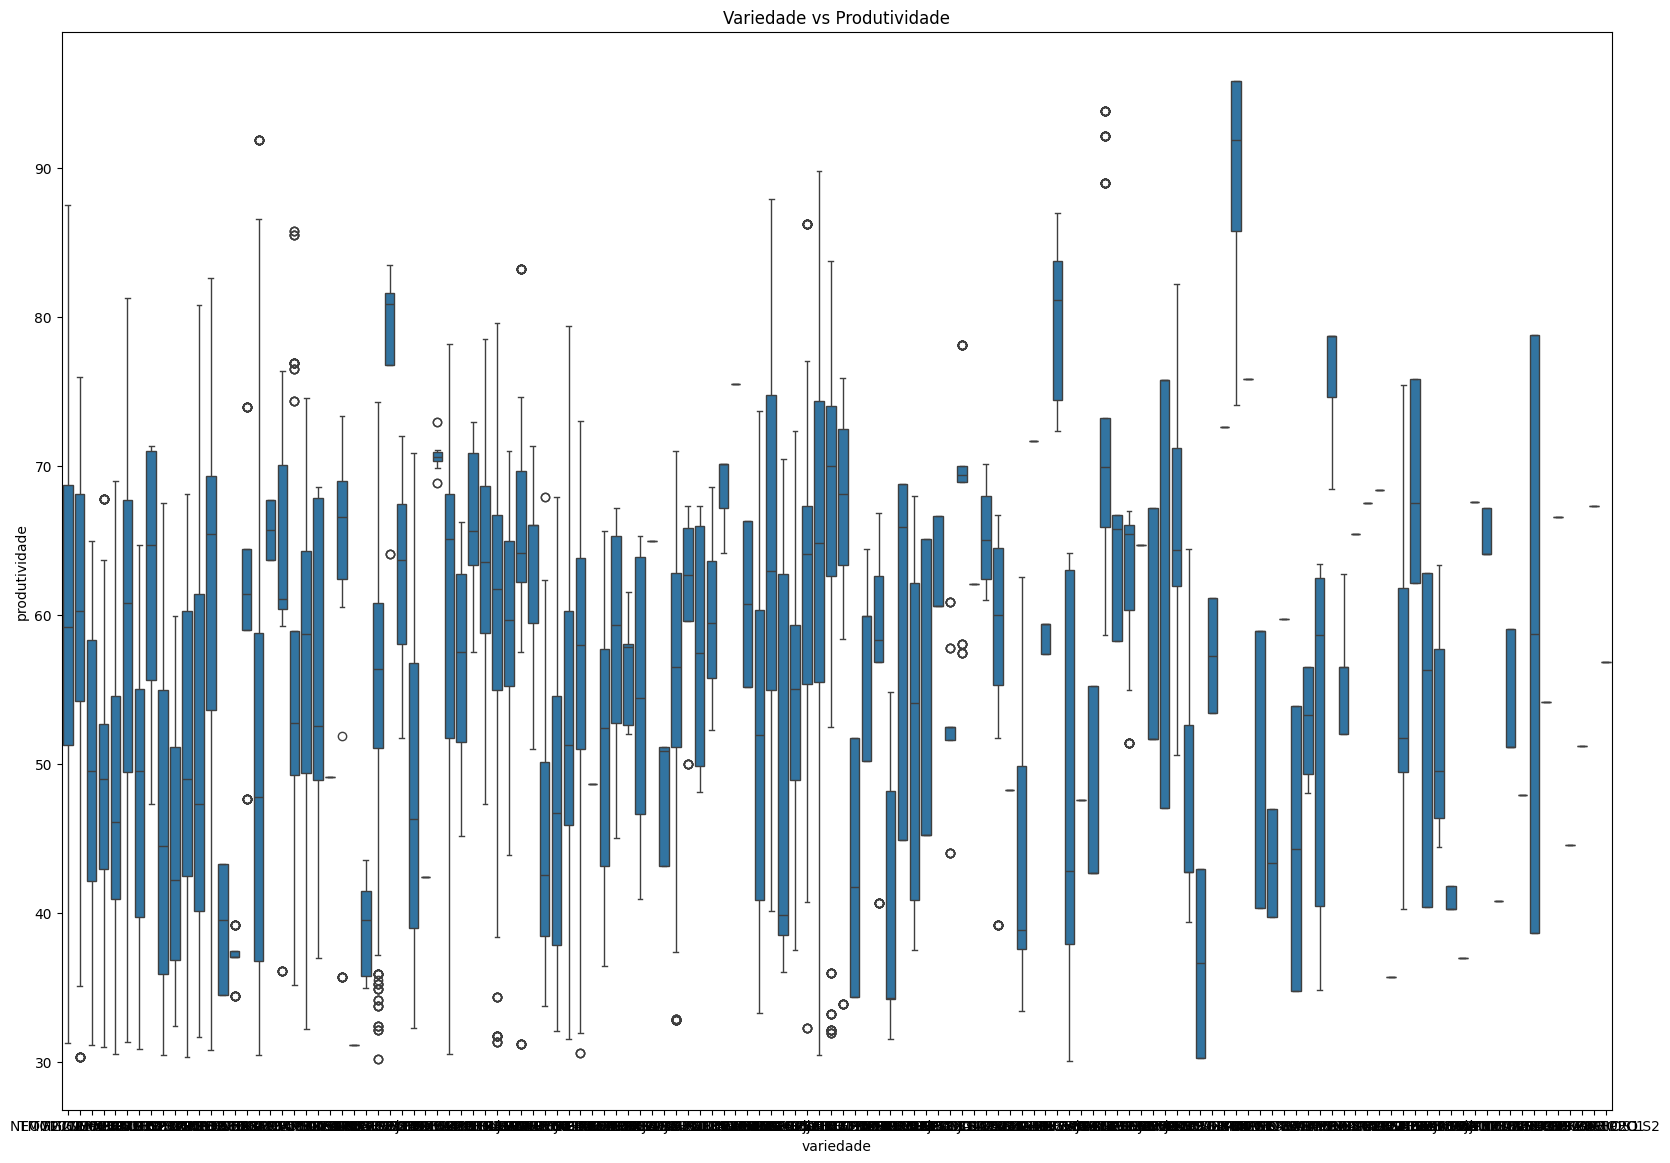

In [40]:
#plotando variedade em relação a produtividade
plt.figure(figsize=(20, 14))
sns.boxplot(x='variedade', y='produtividade', data=data)
plt.title('Variedade vs Produtividade')
plt.show()

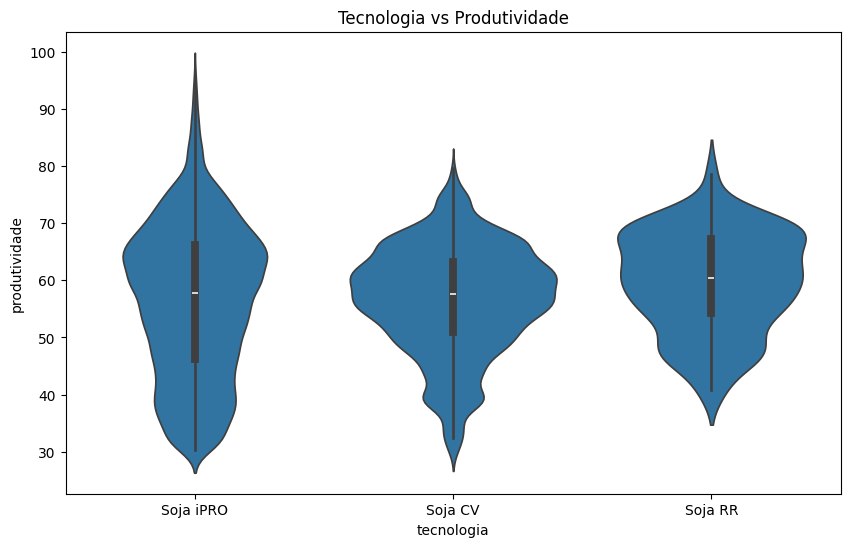

In [41]:
#plotando tecnologia em relação a produtividade
plt.figure(figsize=(10, 6))
sns.violinplot(x='tecnologia', y='produtividade', data=data)
plt.title('Tecnologia vs Produtividade')
plt.show()

In [16]:
radiacao = data['radiacao'].groupby(data['talhaoid']).mean()
chuva = data['chuva'].groupby(data['talhaoid']).mean()
umidade = data['umidade'].groupby(data['talhaoid']).mean()
graus_dias = data['graus_dias'].groupby(data['talhaoid']).mean()

produtividade_talhao = data['produtividade'].groupby(data['talhaoid']).mean()



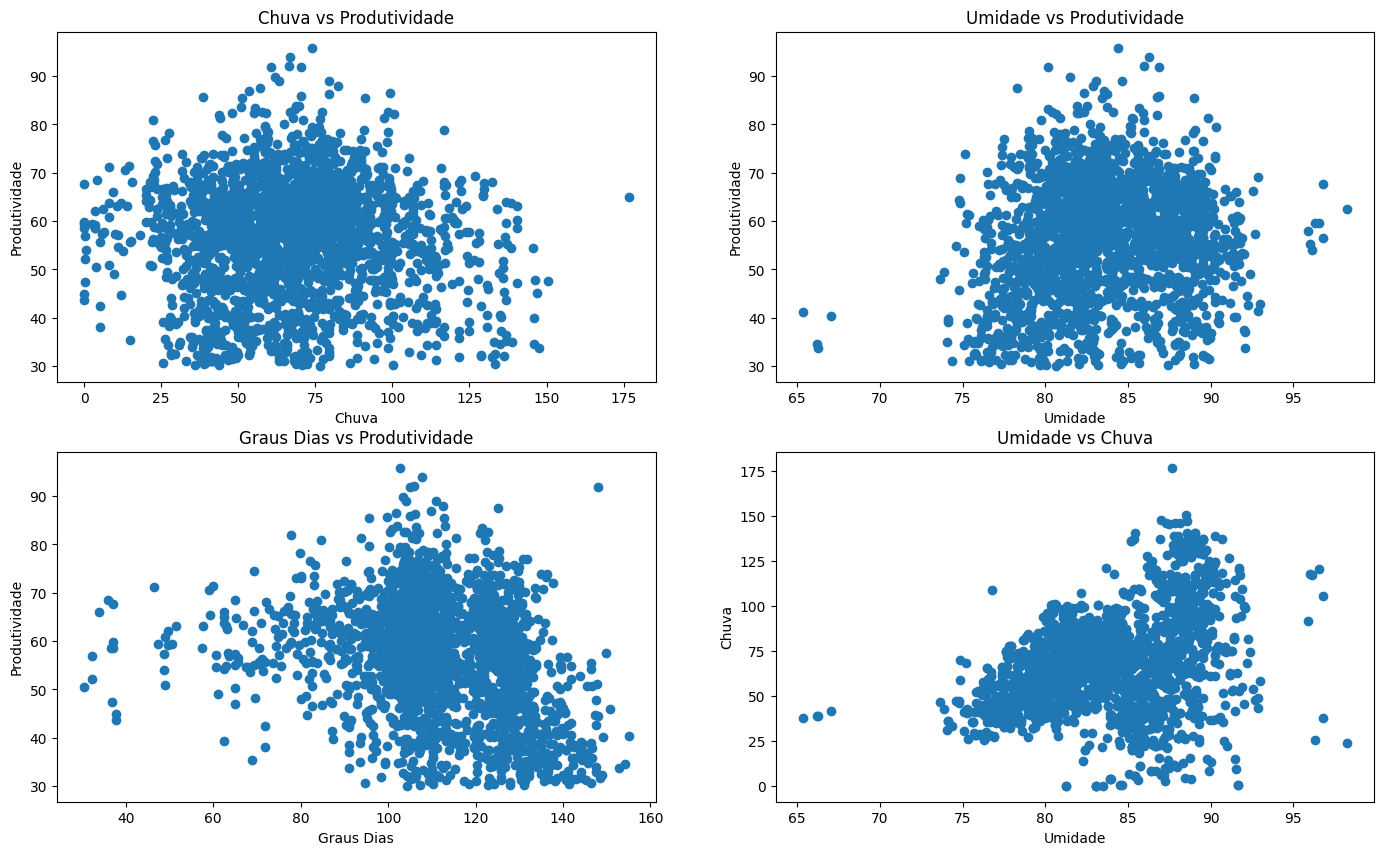

In [30]:


fig, ax = plt.subplots(2,2, figsize=(17, 10))

ax[0,0].scatter(chuva, produtividade_talhao)
ax[0,0].set_title('Chuva vs Produtividade')
ax[0,0].set_xlabel('Chuva') 
ax[0,0].set_ylabel('Produtividade')
ax[0,1].scatter(umidade, produtividade_talhao)
ax[0,1].set_title('Umidade vs Produtividade')
ax[0,1].set_xlabel('Umidade')
ax[0,1].set_ylabel('Produtividade')
ax[1,0].scatter(graus_dias, produtividade_talhao)
ax[1,0].set_title('Graus Dias vs Produtividade')
ax[1,0].set_xlabel('Graus Dias')
ax[1,0].set_ylabel('Produtividade')
ax[1,1].scatter(umidade, chuva)
ax[1,1].set_title('Umidade vs Chuva')
ax[1,1].set_xlabel('Umidade')
ax[1,1].set_ylabel('Chuva')
plt.show()


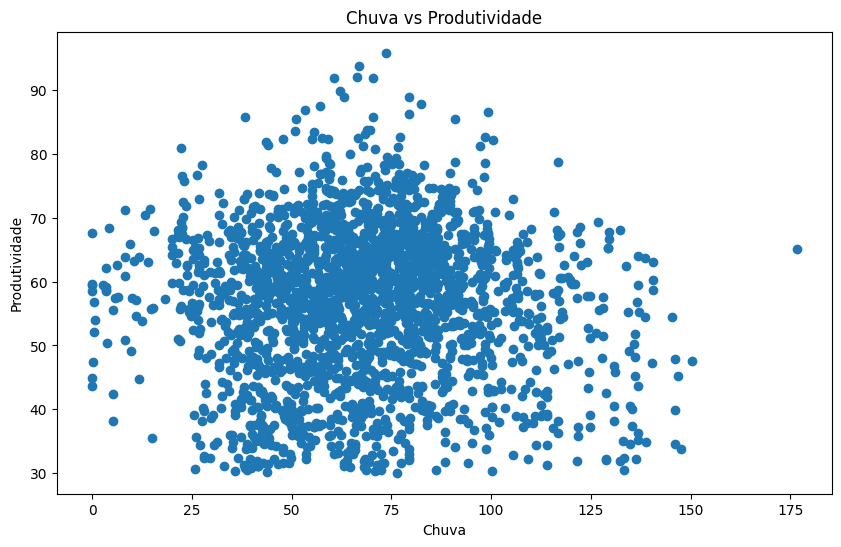

In [24]:
#plotando chuva em relação a produtividade
plt.figure(figsize=(10, 6))
plt.scatter(chuva, produtividade_talhao)
plt.title('Chuva vs Produtividade')
plt.xlabel('Chuva')
plt.ylabel('Produtividade')
plt.show()

## Métricas dos modelos

In [2]:
from utils.query_execution import create_dataframe_from_query

data = create_dataframe_from_query("data/queries/prod_decendios.sql")


In [18]:
data

,fazenda,setor,talhao,talhaoid,safra_periodo,cultura,tecnologia,variedade,decendios,graus_dias,defict_hidrico,chuva,radiacao,umidade,numero_de_dias_agregados,produtividade,texturasolo,safra
0,Itamarati,Ciapar,68,2FCD0000-CF2F-DECA-D2B7-08DB1B2F8000,Soja CV Safra 22/23,Soja,Soja CV,TMG4377 S1,2,118.025,-10.951625,38.0,489.495432,75.810792,10,46.2900,2. Media Arenoso (15~25%),Safra 22-23
1,Itamarati,Ciapar,68,2FCD0000-CF2F-DECA-D2B7-08DB1B2F8000,Soja CV Safra 22/23,Soja,Soja CV,TMG4377 S1,3,126.085,30.981125,80.4,478.955417,79.181125,10,46.2900,2. Media Arenoso (15~25%),Safra 22-23
2,Itamarati,Ciapar,68,2FCD0000-CF2F-DECA-D2B7-08DB1B2F8000,Soja CV Safra 22/23,Soja,Soja CV,TMG4377 S1,4,105.895,-4.261917,42.8,481.960313,80.696063,10,46.2900,2. Media Arenoso (15~25%),Safra 22-23
3,Itamarati,Ciapar,68,2FCD0000-CF2F-DECA-D2B7-08DB1B2F8000,Soja CV Safra 22/23,Soja,Soja CV,TMG4377 S1,5,94.130,-1.078792,44.4,572.291566,59.391854,10,46.2900,2. Media Arenoso (15~25%),Safra 22-23
4,Itamarati,Ciapar,68,2FCD0000-CF2F-DECA-D2B7-08DB1B2F8000,Soja CV Safra 22/23,Soja,Soja CV,TMG4377 S1,6,112.980,-7.243208,41.4,695.303328,78.292854,10,46.2900,2. Media Arenoso (15~25%),Safra 22-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19808,Nova,HORIZONTE,140,88270000-C2E3-2AF2-F32D-08DB1B2F8215,Soja iPRO Safra 22/23,Soja,Soja iPRO,TMG2374IPRO S2,8,99.905,66.455625,112.6,NaN,92.559521,10,75.7800,4. Argiloso (40~60%),Safra 22-23
19809,Nova,HORIZONTE,140,88270000-C2E3-2AF2-F32D-08DB1B2F8215,Soja iPRO Safra 22/23,Soja,Soja iPRO,TMG2374IPRO S2,9,102.730,117.894042,164.2,NaN,93.751563,10,75.7800,4. Argiloso (40~60%),Safra 22-23
19810,Nova,HORIZONTE,140,88270000-C2E3-2AF2-F32D-08DB1B2F8215,Soja iPRO Safra 22/23,Soja,Soja iPRO,TMG2374IPRO S2,10,103.175,67.472083,113.8,NaN,91.554417,10,75.7800,4. Argiloso (40~60%),Safra 22-23
19811,Nova,HORIZONTE,140,88270000-C2E3-2AF2-F32D-08DB1B2F8215,Soja iPRO Safra 22/23,Soja,Soja iPRO,TMG2374IPRO S2,11,113.660,-5.400375,42.4,NaN,84.778646,10,75.7800,4. Argiloso (40~60%),Safra 22-23


In [9]:
prod_menor_70 = data[data['produtividade'] < 70]
prod_maior_90 = data[data['produtividade'] > 90]

C:\Users\Caio~\AppData\Local\Temp\ipykernel_23348\33695049.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['produtividade'])


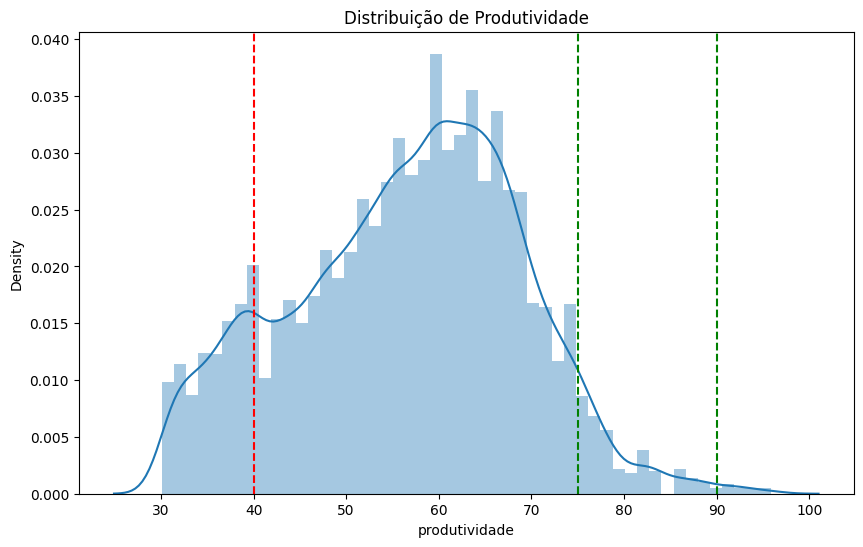

In [17]:
#distribuição de produtividade
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.distplot(data['produtividade'])
#traçando linha pontilhada em 45
plt.axvline(x=40, color='red', linestyle='--')
plt.axvline(x=90, color='green', linestyle='--')
plt.axvline(x=75, color='green', linestyle='--')
plt.title('Distribuição de Produtividade')
plt.show()

In [27]:
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#custom
from models.select_models import select_model
from sklearn.model_selection import cross_val_score
from utils.query_execution import create_dataframe_from_query
from utils.dataprep import prepare_data, split_and_normalize_data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#carregando dados
data = create_dataframe_from_query("data/queries/produtividade_decendios.sql")
data = data[data['decendios'] >= 4].dropna()


columns_to_drop = ['fazenda', 'setor', 'talhao', 'safra', 'safra_periodo', 'numero_de_dias_agregados', 'cultura', 'variedade', 'talhaoid', 'defict_hidrico', 'chuva', 'graus_dias', 'decendios']
categorical_data = [ 'tecnologia', 'texturasolo']
target = 'produtividade'

ndias = data["numero_de_dias_agregados"]
chuva = data["chuva"]
graus_dias = data["graus_dias"]
data["graus_dias_por_dia"] = graus_dias / ndias
data["chuva_por_dia"] = chuva / ndias

#preparando dados
X, Y = prepare_data(data=data,
                    target=target,
                    drop_columns=columns_to_drop, 
                    categorical_columns= categorical_data)
    
dense_data = ['graus_dias_por_dia', 'chuva_por_dia', 'umidade', 'radiacao']
sparse_data = [col for col in X.columns if col not in dense_data]
models = ['lasso','ridge','xgboost', 'gbr', 'rf', 'svr']
scalers = ['standard', 'minmax', 'robust']

In [49]:
from utils.dataprep import lag_variable

for column in ['graus_dias', 'chuva_por_dia']:
    lag_variable(data, [column], 1)

In [50]:
data

,fazenda,setor,talhao,talhaoid,safra,safra_periodo,cultura,tecnologia,variedade,decendios,...,texturasolo,graus_dias_por_dia,chuva_por_dia,produtividade_lag_1,produtividade_lag_3,produtividade_lag_2,['graus_dias']_lag_1,['chuva_por_dia']_lag_1,graus_dias_lag_1,chuva_por_dia_lag_1
0,Tanguro,Anta,163,1BCF0000-7C4E-22A2-069E-08DBBA1CFC16,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO680 IPRO S2,5,...,3. Media Argiloso (25~40%),14.9465,4.24,38.4900,37.3600,37.3600,139.770,3.77,139.770,3.77
1,Tanguro,Anta,163,1BCF0000-7C4E-22A2-069E-08DBBA1CFC16,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO680 IPRO S2,6,...,3. Media Argiloso (25~40%),13.9430,7.04,38.4900,37.3600,38.4900,149.465,4.24,149.465,4.24
2,Tanguro,Anta,163,1BCF0000-7C4E-22A2-069E-08DBBA1CFC16,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO680 IPRO S2,7,...,3. Media Argiloso (25~40%),13.6890,7.16,38.4900,38.4900,38.4900,139.430,7.04,139.430,7.04
3,Tanguro,Anta,163,1BCF0000-7C4E-22A2-069E-08DBBA1CFC16,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO680 IPRO S2,8,...,3. Media Argiloso (25~40%),12.7220,6.28,38.4900,38.4900,38.4900,136.890,7.16,136.890,7.16
4,Tanguro,Anta,163,1BCF0000-7C4E-22A2-069E-08DBBA1CFC16,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO680 IPRO S2,9,...,3. Media Argiloso (25~40%),14.2100,9.44,38.4900,38.4900,38.4900,127.220,6.28,127.220,6.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12022,Itamarati,Ciapar,40,F4C40000-E93D-BA11-EFEC-08DBAE5383A8,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO710 IPRO S2,6,...,4. Argiloso (40~60%),13.1010,0.00,67.5300,57.0900,67.5300,120.245,6.89,120.245,6.89
12023,Itamarati,Ciapar,40,F4C40000-E93D-BA11-EFEC-08DBAE5383A8,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO710 IPRO S2,7,...,4. Argiloso (40~60%),12.7095,3.71,67.5300,67.5300,67.5300,131.010,0.00,131.010,0.00
12024,Itamarati,Ciapar,40,F4C40000-E93D-BA11-EFEC-08DBAE5383A8,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO710 IPRO S2,8,...,4. Argiloso (40~60%),12.3580,3.10,67.5300,67.5300,67.5300,127.095,3.71,127.095,3.71
12025,Itamarati,Ciapar,40,F4C40000-E93D-BA11-EFEC-08DBAE5383A8,Safra 23/24,Soja iPRO Safra 23/24,Soja,Soja iPRO,NEO710 IPRO S2,9,...,4. Argiloso (40~60%),13.0215,1.00,67.5300,67.5300,67.5300,123.580,3.10,123.580,3.10


In [3]:
import pandas as pd
import random

df = pd.DataFrame(data={
    'decendio': [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
    'codigo': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'var1': [random.randint(0, 100) for _ in range(15)],
    'var2': [random.randint(0, 100) for _ in range(15)]
}
                )
transformed_df = df.pivot_table(index='codigo', columns='decendio', values=['var1', 'var2'])
transformed_df.columns = [f'{var}_{decendio}' for var, decendio in transformed_df.columns]

In [4]:
transformed_df

,var1_1,var1_2,var1_3,var2_1,var2_2,var2_3
codigo,,,,,,
1,28.0,50.0,62.0,7.0,13.0,6.0
2,48.0,65.0,15.0,62.0,36.0,15.0
3,76.0,2.0,20.0,17.0,74.0,72.0
4,42.0,36.0,68.0,36.0,30.0,79.0
5,64.0,64.0,86.0,15.0,20.0,48.0


In [2]:
result = ((99/98.44)**0.7) * ((300.15/198)**1.2)
print(result)

1.6539877991993697


In [ ]:
result = (16667 * 17.11 * 2) / (2100 * 5.88)
print(result)